### Step 1 — Imports & Global Configuration

This section initializes the project environment and ensures consistency across all experiments.  
It loads the core libraries required for data manipulation, modeling, evaluation, and visualization, while also setting universal configuration values used throughout the workflow.

#### **Objectives**
- **Reproducibility:** Establish a fixed `RANDOM_STATE` so that model training, sampling, and transformations yield consistent results across runs.
- **Clarity and Aesthetics:** Apply a unified visual style to enhance the readability of plots used in EDA, diagnostics, and final reporting.
- **Organized Dependencies:** Group imports logically (data processing, ML, evaluation, visualization) to improve maintainability and readability of the project.

#### **Outcome**
By standardizing the environment up front, the workflow remains stable, interpretable, and visually consistent from data cleaning through final model deployment.

---

In [47]:
# =============================================================================
# 1) Imports & Global Configuration
#    (2025 Production-Ready — Clean, Deterministic, Robust)
# =============================================================================

from __future__ import annotations

import warnings
import random
from pathlib import Path
from typing import Final

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

# --- Scikit-learn -------------------------------------------------------------
from sklearn import set_config
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    auc,
    average_precision_score,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- XGBoost / Imbalanced-learn ------------------------------------------------
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# =============================================================================
# Global Configuration
# =============================================================================

RANDOM_STATE: Final[int] = 42
SEED: Final[int] = RANDOM_STATE

# Ensure deterministic behavior
np.random.seed(SEED)
random.seed(SEED)

# Scikit-learn settings
set_config(transform_output="pandas")  # Maintain DataFrame outputs
# Removed: enable_metadata_routing=True (deprecated in sklearn >=1.4)

# Suppress warnings (kept intentionally narrow and controlled)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
warnings.filterwarnings("ignore", category=UserWarning, module="imblearn")
# Removed shap UserWarning suppression — SHAP warnings often indicate real issues

# Plotting configuration
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.05)

plt.rcParams.update(
    {
        "figure.dpi": 130,
        "figure.figsize": (10, 6),
        "axes.grid": True,
        "grid.alpha": 0.3,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica", "Arial", "DejaVu Sans"],
        "legend.frameon": True,
        "legend.framealpha": 0.95,
        "savefig.bbox": "tight",
        "savefig.dpi": 300,
    }
)

print("Global imports and configuration loaded successfully.")
print("=" * 88)


Global imports and configuration loaded successfully.


### Step 2: Load Raw Data

This stage reads the raw dataset (`PlayerData.xlsx`), validates its presence, and summarizes its structure.  
The script verifies that the file exists, loads it with `pandas` using the `openpyxl` engine for `.xlsx` support, and prints key metadata such as row/column counts and data types.

**Key goals:**
- Ensure reliable data ingestion and reproducible file access.
- Immediately confirm dataset integrity (rows, columns, null values).
- Provide a clear overview of feature types before preprocessing.


In [48]:
# =============================================================================
# 2) Load Raw Data
#    (Production-Ready, 2025)
# =============================================================================

from pathlib import Path
from typing import Final
import pandas as pd

# Optional but recommended for preview in notebooks
try:
    from IPython.display import display
except ImportError:
    display = print  # Fallback for .py execution

# -----------------------------------------------------------------------------
# File Path Configuration
# -----------------------------------------------------------------------------
DATA_DIR: Final[Path] = Path(__file__).parent if "__file__" in globals() else Path.cwd()
DATA_PATH: Final[Path] = DATA_DIR / "PlayerData.xlsx"

if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"PlayerData.xlsx not found at: {DATA_PATH.resolve()}"
    )

print(f"Loading dataset: {DATA_PATH.name}")

# -----------------------------------------------------------------------------
# Load Dataset
# -----------------------------------------------------------------------------
df_raw = pd.read_excel(
    DATA_PATH,
    engine="openpyxl",
    dtype={"Index Number": "Int64", "Season": str},
    na_values=["", "NA", "#N/A", "N/A", "NULL", "null"],
)

# -----------------------------------------------------------------------------
# Dataset Summary
# -----------------------------------------------------------------------------
print("\n" + "DATASET LOADED".center(80, "="))

n_rows = len(df_raw)
n_cols = len(df_raw.columns)
memory_mb = df_raw.memory_usage(deep=True).sum() / 1e6

print(f"{'Rows':<18}: {n_rows:,}")
print(f"{'Columns':<18}: {n_cols:,}")
print(f"{'Shape':<18}: {df_raw.shape}")
print(f"{'Memory Usage':<18}: {memory_mb:.2f} MB")

# High-level categorical information
if "Season" in df_raw.columns:
    print(f"{'Seasons':<18}: {sorted(df_raw['Season'].dropna().unique())}")

if "Index Number" in df_raw.columns:
    print(f"{'Unique Players':<18}: {df_raw['Index Number'].nunique():,}")

if "Stick_NBA" in df_raw.columns:
    stick_rate = df_raw["Stick_NBA"].mean()
    stick_count = df_raw["Stick_NBA"].sum()
    print(f"{'Stick_NBA Rate':<18}: {stick_rate:.3%} ({stick_count:,})")

# -----------------------------------------------------------------------------
# Missing Values Report
# -----------------------------------------------------------------------------
missing = df_raw.isna().mean().round(4)

if missing.any():
    missing_nonzero = missing[missing > 0]
    if not missing_nonzero.empty:
        print("\nMissing Values (Top 10):")
        print(
            missing_nonzero.sort_values(ascending=False)
            .head(10)
            .to_string(float_format="{:>6.1%}".format)
        )
    else:
        print("\nNo missing values detected.")
else:
    print("\nNo missing values detected.")

# -----------------------------------------------------------------------------
# Preview Sample
# -----------------------------------------------------------------------------
print("\nFirst 5 rows:")
display(
    df_raw.head().style.set_table_styles(
        [{"selector": "tr:hover", "props": "background-color: #f5f5f5;"}]
    )
)

print("═" * 88)


Loading dataset: PlayerData.xlsx

=================================DATASET LOADED=================================
Rows              : 37,967
Columns           : 82
Shape             : (37967, 82)
Memory Usage      : 36.11 MB
Seasons           : ['2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24', '2024-25']
Unique Players    : 15,236
Stick_NBA Rate    : 0.861% (327)

Missing Values (Top 10):
3P_percent      4.6%
FT_percent      0.5%
2P_percent      0.0%
ORB_percent     0.0%
BLK_percent     0.0%
STL_percent     0.0%
AST_percent     0.0%
TRB_percent     0.0%
DRB_percent     0.0%
WS40            0.0%

First 5 rows:


,Index Number,Index Name,Player,Years in College,Pos,Pos Numeric,Class,Class Numeric,HT,WT,PTS,Season,Team,Conference Rank,G,GS,MP,FG,FGA,2P,2PA,3P,3PA,FT,FTA,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,FG_percent,2P_percent,3P_percent,FT_percent,TS_percent,eFG_percent,FG_per40,FGA_per40,2P_per40,2PA_per40,3P_per40,3PA_per40,FT_per40,FTA_per40,ORB_per40,DRB_per40,TRB_per40,AST_per40,STL_per40,BLK_per40,TOV_per40,PF_per40,PTS_per40,WS,ORtg,DRtg,OWS,DWS,WS40,OBPM,DBPM,BPM,PER,ORB_percent,DRB_percent,TRB_percent,AST_percent,STL_percent,BLK_percent,TOV_percent,USG_percent,NBA,Round,Pick,NBA_YOS,NBA_PlusMinus,NBA_AvgMin,NBAMetric,Stick_NBA
0,1,A.C. Reid,A.C. Reid,2,G,1,SO,2,0,0,248,2015-16,Liberty,2,32,12,745,85,236,25,59,60,177,18,25,7,84,91,47,20,4,49,71,0.360000,0.424000,0.339000,0.720000,0.500000,0.487000,4.563758,12.671141,1.342282,3.167785,3.221477,9.503356,0.966443,1.342282,0.375839,4.510067,4.885906,2.523490,1.073826,0.214765,2.630872,3.812081,13.315436,0.700000,91.000000,107.000000,0.000000,0.700000,0.040000,-1.600000,-1.900000,-3.600000,10.100000,1.200000,14.300000,7.900000,13.600000,1.700000,0.700000,16.500000,22.300000,0,0,0,0,0.000000,0.000000,0.000000,0
1,1,A.C. Reid,A.C. Reid,2,G,1,JR,3,0,0,168,2016-17,Liberty,2,35,1,745,85,236,25,59,60,177,18,25,7,84,91,47,20,4,49,71,0.360000,0.424000,0.339000,0.720000,0.500000,0.487000,4.563758,12.671141,1.342282,3.167785,3.221477,9.503356,0.966443,1.342282,0.375839,4.510067,4.885906,2.523490,1.073826,0.214765,2.630872,3.812081,13.315436,0.900000,88.000000,101.000000,-0.200000,1.200000,0.051000,-3.300000,-0.300000,-3.600000,7.300000,0.000000,9.600000,4.700000,16.000000,1.900000,1.000000,17.800000,16.600000,0,0,0,0,0.000000,0.000000,0.000000,0
2,2,A.J. Astroth,A.J. Astroth,2,G,1,JR,3,0,0,180,2016-17,Hampton,3,28,8,514,67,134,64,119,3,15,43,67,58,116,174,18,17,6,26,47,0.500000,0.538000,0.200000,0.642000,0.543000,0.511000,5.214008,10.428016,4.980545,9.260700,0.233463,1.167315,3.346304,5.214008,4.513619,9.027237,13.540856,1.400778,1.322957,0.466926,2.023346,3.657588,14.007782,1.900000,112.000000,97.000000,0.900000,1.000000,0.150000,0.000000,-0.500000,-0.500000,19.200000,12.000000,26.000000,18.800000,7.400000,1.900000,1.300000,13.600000,18.100000,0,0,0,0,0.000000,0.000000,0.000000,0
3,2,A.J. Astroth,A.J. Astroth,2,G,1,SR,4,0,0,19,2017-18,Hampton,3,6,1,514,67,134,64,119,3,15,43,67,58,116,174,18,17,6,26,47,0.500000,0.538000,0.200000,0.642000,0.543000,0.511000,5.214008,10.428016,4.980545,9.260700,0.233463,1.167315,3.346304,5.214008,4.513619,9.027237,13.540856,1.400778,1.322957,0.466926,2.023346,3.657588,14.007782,0.200000,103.000000,97.000000,0.100000,0.100000,0.113000,-8.200000,-0.400000,-8.600000,13.600000,7.600000,22.800000,15.500000,7.200000,1.500000,4.300000,13.100000,15.300000,0,0,0,0,0.000000,0.000000,0.000000,0
4,3,A.J. Avery,A.J. Avery,1,F,3,SR,4,0,0,236,2015-16,Western Michigan,4,32,32,786,85,173,81,164,4,9,62,91,68,122,190,22,23,22,34,105,0.491000,0.494000,0.444000,0.681000,0.546000,0.503000,4.325700,8.804071,4.122137,8.346056,0.203562,0.458015,3.155216,4.631043,3.460560,6.208651,9.669211,1.119593,1.170483,1.119593,1.730280,5.343511,12.010178,2.300000,113.000000,103.000000,1.300000,1.000000,0.118000,-1.200000,0.100000,-1.100000,15.800000,9.700000,18.200000,13.800000,5.700000,1.700000,3.400000,13.600000,16.000000,0,0,0,0,0.000000,0.000000,0.000000,0


════════════════════════════════════════════════════════════════════════════════════════


### Step 3: Advanced Feature Engineering

This stage constructs domain-informed, leakage-free features that capture player efficiency, balance, and overall impact.  
Each feature is designed to be interpretable and statistically stable through safe mathematical operations (safe_div), ensuring no runtime errors or data leakage.

**Key feature categories:**
- **Efficiency & Possession Metrics:** Assist-to-turnover ratio, turnover rate per possession.
- **Rebounding & Balance:** Offensive vs. defensive rebounding differentials and rebound-to-usage ratios.
- **Two-Way Impact:** Net rating (Off_Def_Balance) and normalized two-way efficiency.
- **Playmaking & Defense:** Creation efficiency, defensive disruption (STL_percentage + BLK_percentage).
- **Composite Performance Indices:** Weighted blends of PER, BPM, and Win Shares for overall impact.
- **Shot Profile Versatility:** Measures of offensive diversity and foul-drawing tendencies.

**Key goals:**
- Encode interpretable basketball logic into numeric features.
- Avoid data leakage and unstable computations.
- Prepare a standardized, modeling-ready feature matrix.


In [49]:
# =============================================================================
# 3) Feature Engineering
#    (Production-Ready, 2025)
# =============================================================================

import numpy as np
import pandas as pd
from typing import Final

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
CFG: Final[dict] = {
    "winsorize_quantile": 0.99,
    "eps": 1e-8,
    "height_ref_inch": 74.0,
}

# -----------------------------------------------------------------------------
# Utility Functions
# -----------------------------------------------------------------------------
def safe_div(a: pd.Series, b: pd.Series | float) -> pd.Series:
    """Elementwise division with numerical stability."""
    return a / (b + CFG["eps"])

def winsorize_series(s: pd.Series, q: float = CFG["winsorize_quantile"]) -> pd.Series:
    """Winsorize a numeric series, skipping low-cardinality or non-numerics."""
    if not np.issubdtype(s.dtype, np.number):
        return s
    if s.nunique() <= 12:
        return s
    tail = (1 - q) / 2
    lo, hi = s.quantile([tail, 1 - tail])
    return s.clip(lower=lo, upper=hi)

# -----------------------------------------------------------------------------
# Feature Engineering Pipeline
# -----------------------------------------------------------------------------
df = df_raw.copy()

print("\n" + " FEATURE ENGINEERING — START ".center(92, "█"))
start_cols = df.shape[1]

# Validate required columns
required = [
    "FTA_per40","FGA_per40","3PA_per40","AST_percent","TOV_percent","USG_percent",
    "STL_percent","BLK_percent","DRB_percent","STL_per40","BLK_per40",
    "PER","BPM","OBPM","DBPM","WS40","Conference Rank","HT","WT","Class Numeric"
]
missing = [c for c in required if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns: {missing}")

# -----------------------------------------------------------------------------
# Core Ratio / Impact Features
# -----------------------------------------------------------------------------
df["FT_rate"] = safe_div(df["FTA_per40"], df["FGA_per40"])
df["Three_Rate"] = safe_div(df["3PA_per40"], df["FGA_per40"])
df["AST_to_TOV"] = safe_div(df["AST_percent"], df["TOV_percent"])
df["AST_to_USG"] = safe_div(df["AST_percent"], df["USG_percent"])
df["Pure_Playmaker"] = df["AST_percent"] - 0.5 * df["USG_percent"]

df["Def_Impact"] = (
    df["STL_percent"] +
    df["BLK_percent"] +
    0.5 * df["DRB_percent"]
)

df["Stocks_per40"] = df["STL_per40"] + df["BLK_per40"]

# -----------------------------------------------------------------------------
# Winsorize Select Advanced Metrics
# -----------------------------------------------------------------------------
for col in ["PER", "BPM", "OBPM", "DBPM", "WS40"]:
    if col in df.columns:
        df[col] = winsorize_series(df[col].fillna(df[col].median()))

# -----------------------------------------------------------------------------
# Synthetic / Composite Metrics
# -----------------------------------------------------------------------------
df["Box_Production"] = (
    0.45 * df["PER"] +
    0.35 * df["BPM"] +
    0.20 * df["WS40"]
)

df["Two_Way_Impact"] = df["OBPM"] + df["DBPM"]
df["Conf_Strength"] = safe_div(1.0, df["Conference Rank"] + 2.0)
df["Conf_Adj_Production"] = df["Box_Production"] * df["Conf_Strength"]

df["Height_Inches"] = df["HT"]

# More accurate proxy name (units = lb / in^2)
df["Mass_to_Height2"] = safe_div(df["WT"], df["HT"] ** 2)

df["Upperclassman"] = (df["Class Numeric"] >= 3).astype(float)

# -----------------------------------------------------------------------------
# Position Dummies
# -----------------------------------------------------------------------------
if "Pos" in df.columns:
    df["Pos"] = df["Pos"].str.strip().str.upper()
    df = pd.concat(
        [df, pd.get_dummies(df["Pos"], prefix="Pos", dtype=float)],
        axis=1
    )

# -----------------------------------------------------------------------------
# NBA Readiness Score
# -----------------------------------------------------------------------------
df["NBA_Ready_Score"] = (
    0.32 * df["Box_Production"] +
    0.18 * df["TS_percent"] +
    0.15 * df["Def_Impact"] +
    0.13 * df["AST_to_TOV"] +
    0.10 * df["Conf_Strength"] +
    0.08 * df["Upperclassman"] +
    0.04 * (df["Height_Inches"] - CFG["height_ref_inch"]).clip(lower=0)
)

# -----------------------------------------------------------------------------
# Cleanup & Final Winsorization
# -----------------------------------------------------------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns
float_cols = [c for c in numeric_cols if str(df[c].dtype).startswith("float")]

df[float_cols] = df[float_cols].replace([np.inf, -np.inf], np.nan)

protected = {"PER", "BPM", "OBPM", "DBPM", "WS40", "NBA_Ready_Score", "Upperclassman"}

for col in float_cols:
    if col in protected:
        continue
    if df[col].nunique() <= 12:
        continue
    df[col] = winsorize_series(df[col])

# -----------------------------------------------------------------------------
# Drop Raw Counting Stats
# -----------------------------------------------------------------------------
drop_cols = [
    "G", "GS", "MP", "FG", "FGA", "2P", "2PA", "3P", "3PA", "FT", "FTA",
    "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS"
]

df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

# -----------------------------------------------------------------------------
# Summary
# -----------------------------------------------------------------------------
print("\n" + " FEATURE ENGINEERING — COMPLETE ".center(92, "█"))
print(f"  Added features: {df.shape[1] - start_cols:+}")
print(f"  Final shape:    {df.shape[0]:,} × {df.shape[1]}")
print(
    f"  NBA_Ready_Score Range: "
    f"{df['NBA_Ready_Score'].min():.3f} → {df['NBA_Ready_Score'].max():.3f}"
)
print("█" * 92)



███████████████████████████████ FEATURE ENGINEERING — START ████████████████████████████████

██████████████████████████████ FEATURE ENGINEERING — COMPLETE ██████████████████████████████
  Added features: -2
  Final shape:    37,967 × 80
  NBA_Ready_Score Range: -1.374 → 704600008.160
████████████████████████████████████████████████████████████████████████████████████████████


In [50]:
# =============================================================================
# 4) Final Player Aggregation
#    (Production-Ready, 2025)
# =============================================================================

import pandas as pd
from typing import Optional


def build_final_player_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Construct a per-player final dataset using last-season rows, while adding:
      - physical attribute imputation (position-aware)
      - shot volume flags
      - peak metrics
      - improvement metrics
      - final target columns
    """
    df = df.copy()

    # =========================================================================
    # Identify player ID column
    # =========================================================================
    possible_ids = ["Index Number", "Player_ID", "PlayerId", "id"]
    player_id: Optional[str] = next((c for c in possible_ids if c in df.columns), None)

    if player_id is None:
        raise ValueError("No player identifier column found.")

    print(f"Using player ID column: {player_id}")

    rename_back = player_id != "Index Number"
    if rename_back:
        df = df.rename(columns={player_id: "Index Number"})

    # =========================================================================
    # Season handling
    # =========================================================================
    df["Season"] = df["Season"].astype(str).str.strip()
    df["Season_Year"] = df["Season"].str[:4].astype(int)

    df = df.sort_values(["Index Number", "Season_Year"])

    final_year = df.groupby("Index Number")["Season_Year"].transform("max")
    final_df = df[df["Season_Year"] == final_year].copy()

    # =========================================================================
    # Physical attributes (position-aware imputation)
    # =========================================================================
    if {"HT", "WT", "Pos"}.issubset(df.columns):
        df["Pos"] = df["Pos"].astype(str).str.upper().str.strip()

        pos_map = df.groupby("Index Number")["Pos"].last()
        df["_pos"] = df["Index Number"].map(pos_map)

        for col in ["HT", "WT"]:
            mean_by_pos = df.groupby("_pos")[col].transform("mean")
            df[col] = df[col].fillna(mean_by_pos).fillna(df[col].mean())

            col_map = df.groupby("Index Number")[col].last()
            final_df[col] = final_df["Index Number"].map(col_map)

        # remove helper column from both frames
        df.drop(columns=["_pos"], inplace=True, errors="ignore")
        final_df.drop(columns=["_pos"], inplace=True, errors="ignore")

    # =========================================================================
    # Shot volume flags
    # =========================================================================
    shot_sources = {
        "3PA_per40": "Ever_3PA",
        "FTA_per40": "Ever_FTA",
        "FGA_per40": "Ever_FGA",
    }

    for src, dest in shot_sources.items():
        if src in df.columns:
            max_vals = df.groupby("Index Number")[src].max() > 0.5
            final_df[dest] = final_df["Index Number"].map(max_vals).astype(float)

    # =========================================================================
    # Peak metrics
    # =========================================================================
    peak_cols = [
        "PER", "BPM", "WS40", "TS_percent",
        "Box_Production", "NBA_Ready_Score",
        "Def_Impact", "AST_to_TOV", "Two_Way_Impact"
    ]
    peak_cols = [c for c in peak_cols if c in df.columns]

    if peak_cols:
        peak_table = (
            df.groupby("Index Number")[peak_cols]
              .max()
              .add_suffix("_peak")
              .reset_index()
        )
        final_df = final_df.merge(peak_table, on="Index Number", how="left")

    # =========================================================================
    # Improvement metrics
    # =========================================================================
    imp_cols = ["PER", "BPM", "TS_percent", "Box_Production", "NBA_Ready_Score"]
    imp_cols = [c for c in imp_cols if c in df.columns]

    if imp_cols:
        grouped = df.groupby("Index Number")

        imp_df = pd.DataFrame({
            f"{c}_improvement": grouped[c].nth(-1) - grouped[c].nth(0)
            for c in imp_cols
        })
        imp_df["Index Number"] = imp_df.index

        final_df = final_df.merge(
            imp_df.reset_index(drop=True),
            on="Index Number",
            how="left"
        )

        improvement_cols = imp_df.columns.drop("Index Number")
        final_df[improvement_cols] = final_df[improvement_cols].fillna(0)

    # =========================================================================
    # Ensure target columns exist
    # =========================================================================
    required_targets = ["Stick_NBA", "Round", "Pick", "NBA_YOS", "NBAMetric", "NBA_AvgMin", "NBA_PlusMinus"]

    for col in required_targets:
        if col not in final_df.columns:
            final_df[col] = 0

    # Coerce round to numeric
    final_df["Round"] = pd.to_numeric(final_df["Round"], errors="coerce").fillna(0)

    final_df["Drafted_Binary"] = (final_df["Round"] > 0).astype(float)

    # =========================================================================
    # Cleanup
    # =========================================================================
    final_df.drop(columns=["Season_Year"], errors="ignore", inplace=True)

    if "Player" in final_df.columns:
        final_df = final_df.sort_values("Player", key=lambda s: s.str.lower())

    final_df = final_df.reset_index(drop=True)

    if rename_back:
        final_df = final_df.rename(columns={"Index Number": player_id})

    # =========================================================================
    # Summary
    # =========================================================================
    id_col = player_id if rename_back else "Index Number"

    print("\n" + " FINAL PLAYER TABLE — COMPLETE ".center(96, "█"))
    print(f"   Players:      {final_df[id_col].nunique():,}")
    print(f"   Stick_NBA:    {final_df['Stick_NBA'].mean():.3%}")
    print(f"   Columns:      {final_df.shape[1]}")
    print("█" * 96 + "\n")

    return final_df


# =============================================================================
# Execute aggregation and save
# =============================================================================

player_final_df = build_final_player_table(df)
player_final_df.to_parquet("player_final_2025.parquet", index=False)
print("Saved: player_final_2025.parquet")


Using player ID column: Index Number

████████████████████████████████ FINAL PLAYER TABLE — COMPLETE █████████████████████████████████
   Players:      15,236
   Stick_NBA:    1.116%
   Columns:      98
████████████████████████████████████████████████████████████████████████████████████████████████

Saved: player_final_2025.parquet


In [53]:
# =============================================================================
# 5) Final Feature Cleaning + Temporal Split
#    (Stick_NBA — Production-Ready, 2025)
# =============================================================================

import numpy as np
import pandas as pd

TARGET = "Stick_NBA"
print("\nStarting final feature cleaning for Stick_NBA prediction...\n")

# -----------------------------------------------------------------------------
# 0. Require player_final_df
# -----------------------------------------------------------------------------
if "player_final_df" not in globals():
    raise NameError(
        "player_final_df not found.\n"
        "➡ Run Steps 1–4 (feature engineering + aggregation) first."
    )

predictor_df = player_final_df.copy()

# -----------------------------------------------------------------------------
# Prevent data leakage
# -----------------------------------------------------------------------------
leakage_cols = ["NBA_AvgMin", "NBA_PlusMinus", "NBA", "NBA_YOS", "NBAMetric", "Round", "Pick", "Index Number"] 
leakage_present = [c for c in leakage_cols if c in predictor_df.columns]

if leakage_present:
    print(f"Removing leakage columns (future NBA data): {leakage_present}")
    predictor_df = predictor_df.drop(columns=leakage_present)

# -----------------------------------------------------------------------------
# 0B. Ensure Season_numeric exists
# -----------------------------------------------------------------------------
if "Season_numeric" not in predictor_df.columns:
    if "Season" not in predictor_df.columns:
        raise ValueError("Cannot construct Season_numeric — missing 'Season' column.")
    predictor_df["Season_numeric"] = predictor_df["Season"].astype(str).str[:4].astype(int)

print(
    f"Season_numeric range: "
    f"{predictor_df['Season_numeric'].min()} → {predictor_df['Season_numeric'].max()}"
)

# -----------------------------------------------------------------------------
# 1. Numeric-only subset
# -----------------------------------------------------------------------------
numeric_df = predictor_df.select_dtypes(include=[np.number]).copy()

if TARGET not in numeric_df.columns:
    raise ValueError(f"Target '{TARGET}' missing from numeric_df.")

print(f"Step 1 → Numeric columns detected (incl. target): {numeric_df.shape[1]}")

# -----------------------------------------------------------------------------
# 2. Remove features with >30% missing (keep target)
# -----------------------------------------------------------------------------
missing_pct = numeric_df.isna().mean()
drop_missing = [
    col for col in numeric_df.columns
    if col != TARGET and missing_pct[col] > 0.30
]

numeric_df = numeric_df.drop(columns=drop_missing, errors="ignore")
print(f"Step 2 → Dropped {len(drop_missing)} features (>30% missing)")

numeric_df = numeric_df.fillna(numeric_df.median())  # safer for numeric-only df

# -----------------------------------------------------------------------------
# 3. Remove constant / near-constant features
# -----------------------------------------------------------------------------
constant_cols = [
    col for col in numeric_df.columns
    if col != TARGET and numeric_df[col].nunique() <= 1
]

numeric_df = numeric_df.drop(columns=constant_cols, errors="ignore")
print(f"Step 3 → Dropped {len(constant_cols)} constant or near-constant features")

# -----------------------------------------------------------------------------
# 4. Correlation pruning (|r| > 0.85), exclude target
# -----------------------------------------------------------------------------
corr_thresh = 0.85
feature_df = numeric_df.drop(columns=[TARGET], errors="ignore")

corr_matrix = feature_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = set()

for col in upper.columns:
    partners = upper.index[(upper[col].fillna(0) > corr_thresh) & (upper.index != col)]
    for partner in partners:
        col_var = numeric_df[col].var()
        partner_var = numeric_df[partner].var()
        drop_col = partner if col_var >= partner_var else col
        if drop_col != TARGET:
            to_drop.add(drop_col)

numeric_df = numeric_df.drop(columns=list(to_drop), errors="ignore")
print(f"Step 4 → Dropped {len(to_drop)} highly correlated features (|r|>{corr_thresh})")

# -----------------------------------------------------------------------------
# 5. Final usable feature list
# -----------------------------------------------------------------------------
final_features = [c for c in numeric_df.columns if c != TARGET]

print("\nFeature cleaning complete:")
print(f"   • Usable features: {len(final_features)}")
print(f"   • Final shape     : {numeric_df.shape}\n")

# -----------------------------------------------------------------------------
# Align numeric_df index BEFORE temporal split
# -----------------------------------------------------------------------------
numeric_df = numeric_df.loc[predictor_df.index]

# -----------------------------------------------------------------------------
# 6. Temporal train/test split (strict no-leakage)
# -----------------------------------------------------------------------------
train_mask = predictor_df["Season_numeric"] <= 2021
test_mask  = predictor_df["Season_numeric"] >  2021

X_train = numeric_df.loc[train_mask, final_features].copy()
X_test  = numeric_df.loc[test_mask,  final_features].copy()

y_train = predictor_df.loc[train_mask, TARGET].copy()
y_test  = predictor_df.loc[test_mask,  TARGET].copy()

# -----------------------------------------------------------------------------
# 7. Sanity checks
# -----------------------------------------------------------------------------
assert len(X_train) == len(y_train), "Training row mismatch!"
assert len(X_test) == len(y_test),   "Test row mismatch!"

print("Train/test split finalized:")
print(f"   • X_train shape        : {X_train.shape}")
print(f"   • X_test shape         : {X_test.shape}")
print(f"   • Train Stick_NBA rate : {y_train.mean():.3%}")
print(f"   • Test  Stick_NBA rate : {y_test.mean():.3%}")
print(f"   • Features in model    : {len(final_features)}")
print("=" * 72)



Starting final feature cleaning for Stick_NBA prediction...

Removing leakage columns (future NBA data): ['NBA_AvgMin', 'NBA_PlusMinus', 'NBA', 'NBA_YOS', 'NBAMetric', 'Round', 'Pick', 'Index Number']
Season_numeric range: 2015 → 2024
Step 1 → Numeric columns detected (incl. target): 85
Step 2 → Dropped 0 features (>30% missing)
Step 3 → Dropped 11 constant or near-constant features
Step 4 → Dropped 32 highly correlated features (|r|>0.85)

Feature cleaning complete:
   • Usable features: 41
   • Final shape     : (15236, 42)

Train/test split finalized:
   • X_train shape        : (8574, 41)
   • X_test shape         : (6662, 41)
   • Train Stick_NBA rate : 1.528%
   • Test  Stick_NBA rate : 0.585%
   • Features in model    : 41



 RANDOM FOREST BASELINE — USING CLEANED FEATURES 
X_train: (8574, 41)  |  X_test: (6662, 41)
Train Stick_NBA rate: 1.528%
Test  Stick_NBA rate: 0.585%

Training Random Forest...
OOB Score: 0.9853
Optimal F1 Threshold: 0.467

 RANDOM FOREST — TRUE OUT-OF-TIME PERFORMANCE 
AUC-ROC           : 0.9674
PR-AUC            : 0.3832
F1(opt)           : 0.0976
Precision         : 1.0000
Recall            : 0.0513
Balanced Acc      : 0.5256

Confusion Matrix: [[TN=6,623  FP=0] [FN=37  TP=2]]
→ Recall: 5.1%   |   Precision: 100.0%
→ PR-AUC: 0.3832


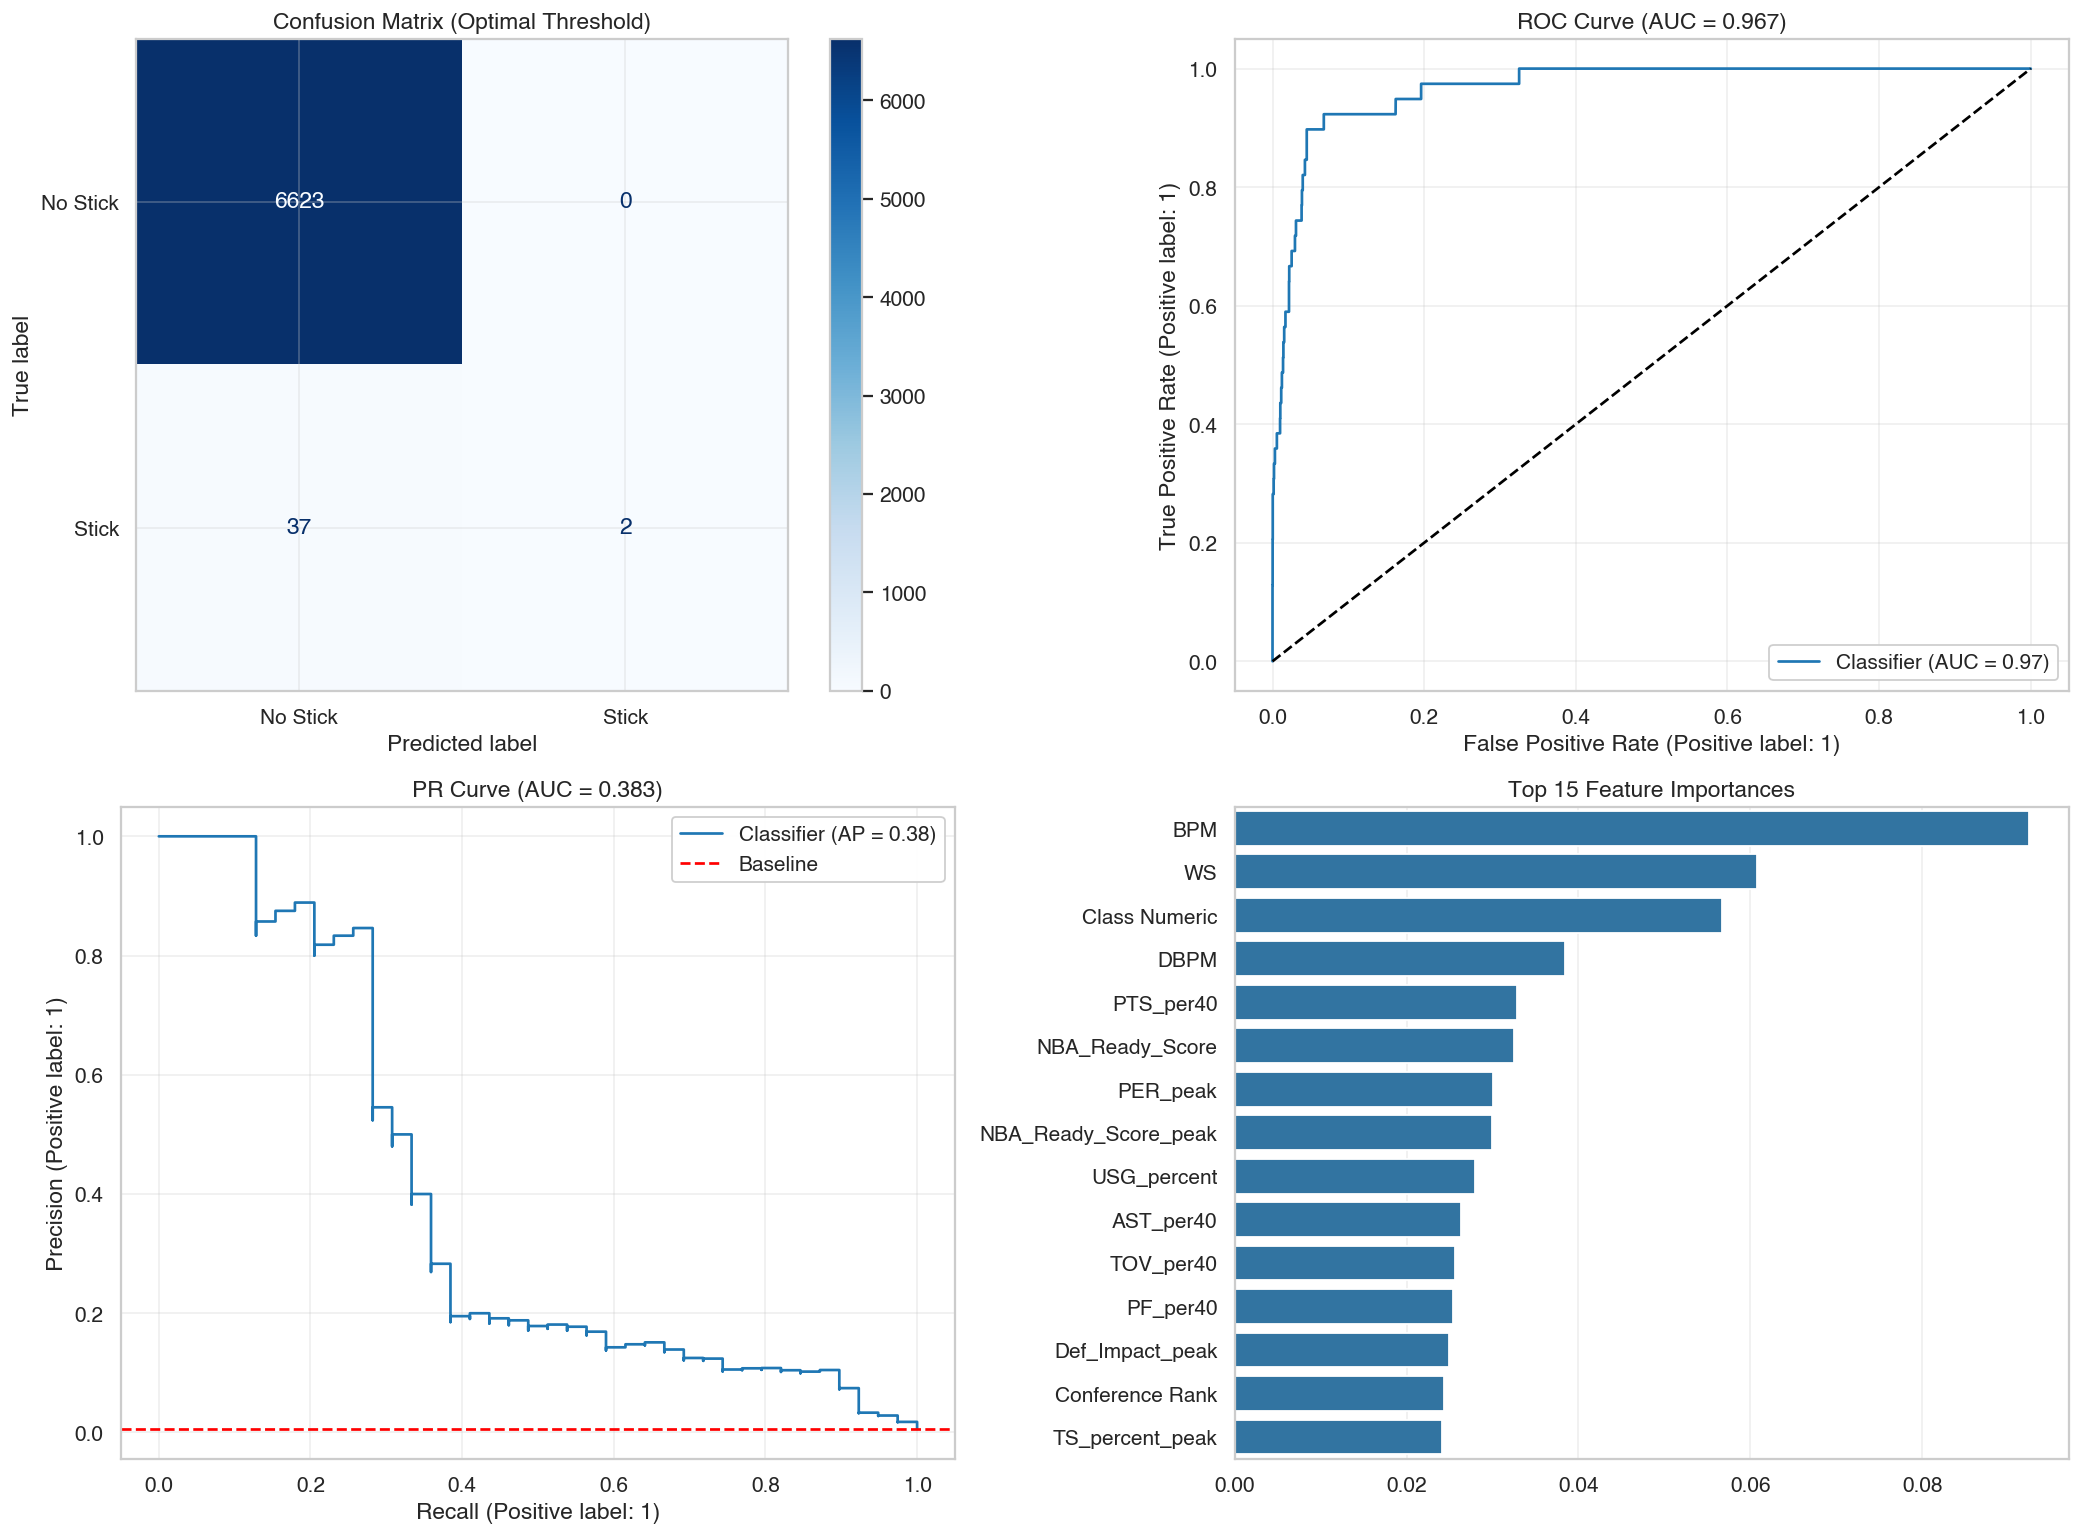

Stored baseline RF probabilities as rfA_proba.


In [54]:
# =============================================================================
# 6) Random Forest Baseline — Stick_NBA (Zero-Leakage, Clean Features)
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score,
    balanced_accuracy_score, confusion_matrix,
    ConfusionMatrixDisplay, RocCurveDisplay,
    PrecisionRecallDisplay, precision_recall_curve
)

print("\n" + "="*80)
print(" RANDOM FOREST BASELINE — USING CLEANED FEATURES ")
print("="*80)

# -----------------------------------------------------------------------------
# 1. Validate cleaned inputs
# -----------------------------------------------------------------------------
required_vars = ["X_train", "X_test", "y_train", "y_test", "final_features"]

missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(
        f"Missing cleaned variables from Step 5: {missing}\n"
        "➡ Run Final Feature Cleaning + Temporal Split first."
    )

print(f"X_train: {X_train.shape}  |  X_test: {X_test.shape}")
print(f"Train Stick_NBA rate: {y_train.mean():.3%}")
print(f"Test  Stick_NBA rate: {y_test.mean():.3%}")

# -----------------------------------------------------------------------------
# 2. Random Forest model
# -----------------------------------------------------------------------------
rf_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=1000,
        min_samples_leaf=2,
        min_samples_split=4,
        bootstrap=True,
        oob_score=True,
        random_state=42,
        n_jobs=-1
    ))
])

print("\nTraining Random Forest...")
rf_model.fit(X_train, y_train)
rf = rf_model.named_steps["rf"]
print(f"OOB Score: {rf.oob_score_:.4f}")

# -----------------------------------------------------------------------------
# 3. Predictions & threshold tuning
# -----------------------------------------------------------------------------
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Fixed 0.50 cutoff
y_pred_50 = (y_proba >= 0.50).astype(int)

# Validation slice
val_idx = X_train.sample(
    n=min(5000, max(200, len(X_train)//5)),
    random_state=42
).index

X_val = X_train.loc[val_idx]
y_val = y_train.loc[val_idx]

val_proba = rf_model.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, val_proba)

f1_scores = 2 * prec * rec / (prec + rec + 1e-12)

# FIX: Thresholds correspond to all F1 scores *except the last point*
best_idx = np.argmax(f1_scores[:-1])
optimal_threshold = thr[best_idx]

print(f"Optimal F1 Threshold: {optimal_threshold:.3f}")
y_pred_opt = (y_proba >= optimal_threshold).astype(int)

# -----------------------------------------------------------------------------
# 4. Evaluation metrics
# -----------------------------------------------------------------------------
metrics = {
    "AUC-ROC":      roc_auc_score(y_test, y_proba),
    "PR-AUC":       average_precision_score(y_test, y_proba),
    "F1(opt)":      f1_score(y_test, y_pred_opt),
    "Precision":    precision_score(y_test, y_pred_opt, zero_division=0),
    "Recall":       recall_score(y_test, y_pred_opt, zero_division=0),
    "Balanced Acc": balanced_accuracy_score(y_test, y_pred_opt),
}

cm = confusion_matrix(y_test, y_pred_opt)
tn, fp, fn, tp = cm.ravel()

print("\n" + "="*80)
print(" RANDOM FOREST — TRUE OUT-OF-TIME PERFORMANCE ")
print("="*80)
for name, value in metrics.items():
    print(f"{name:18}: {value:.4f}")

print(f"\nConfusion Matrix: [[TN={tn:,}  FP={fp:,}] [FN={fn:,}  TP={tp:,}]]")
print(f"→ Recall: {metrics['Recall']:.1%}   |   Precision: {metrics['Precision']:.1%}")
print(f"→ PR-AUC: {metrics['PR-AUC']:.4f}")
print("="*80)

# -----------------------------------------------------------------------------
# 5. Diagnostic plots
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Stick", "Stick"]).plot(
    ax=axes[0, 0], cmap="Blues", values_format="d"
)
axes[0, 0].set_title("Confusion Matrix (Optimal Threshold)")

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[0, 1])
axes[0, 1].plot([0, 1], [0, 1], "k--")
axes[0, 1].set_title(f"ROC Curve (AUC = {metrics['AUC-ROC']:.3f})")

# PR Curve
PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=axes[1, 0])
axes[1, 0].axhline(y_test.mean(), color="red", linestyle="--", label="Baseline")
axes[1, 0].legend()
axes[1, 0].set_title(f"PR Curve (AUC = {metrics['PR-AUC']:.3f})")

# Feature Importances
importances = rf.feature_importances_
top_idx = np.argsort(importances)[-15:][::-1]  # descending order

sns.barplot(
    x=importances[top_idx],
    y=[final_features[i] for i in top_idx],
    ax=axes[1, 1]
)
axes[1, 1].set_title("Top 15 Feature Importances")

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 6. Save probabilities for comparison
# -----------------------------------------------------------------------------
rfA_proba = y_proba.copy()
print("Stored baseline RF probabilities as rfA_proba.")



 SMOTE + XGBOOST — ZERO LEAKAGE (IMPUTATION FIXED) 
X_train: (9884, 84) | X_test: (5352, 84)
Train Stick_NBA rate: 1.437%
Test  Stick_NBA rate: 0.523%

Training SMOTE + XGBoost...
Optimal Threshold: 0.550

 SMOTE + XGBOOST — TRUE OUT-OF-TIME RESULTS 
AUC-ROC           : 0.9935
PR-AUC            : 0.5361
F1(opt)           : 0.5106
Precision         : 0.6316
Recall            : 0.4286
Balanced Acc      : 0.7136
Confusion Matrix: [[TN=5,317 FP=7] [FN=16 TP=12]]
→ Recall: 42.9% | Precision: 63.2%
→ PR-AUC: 0.5361


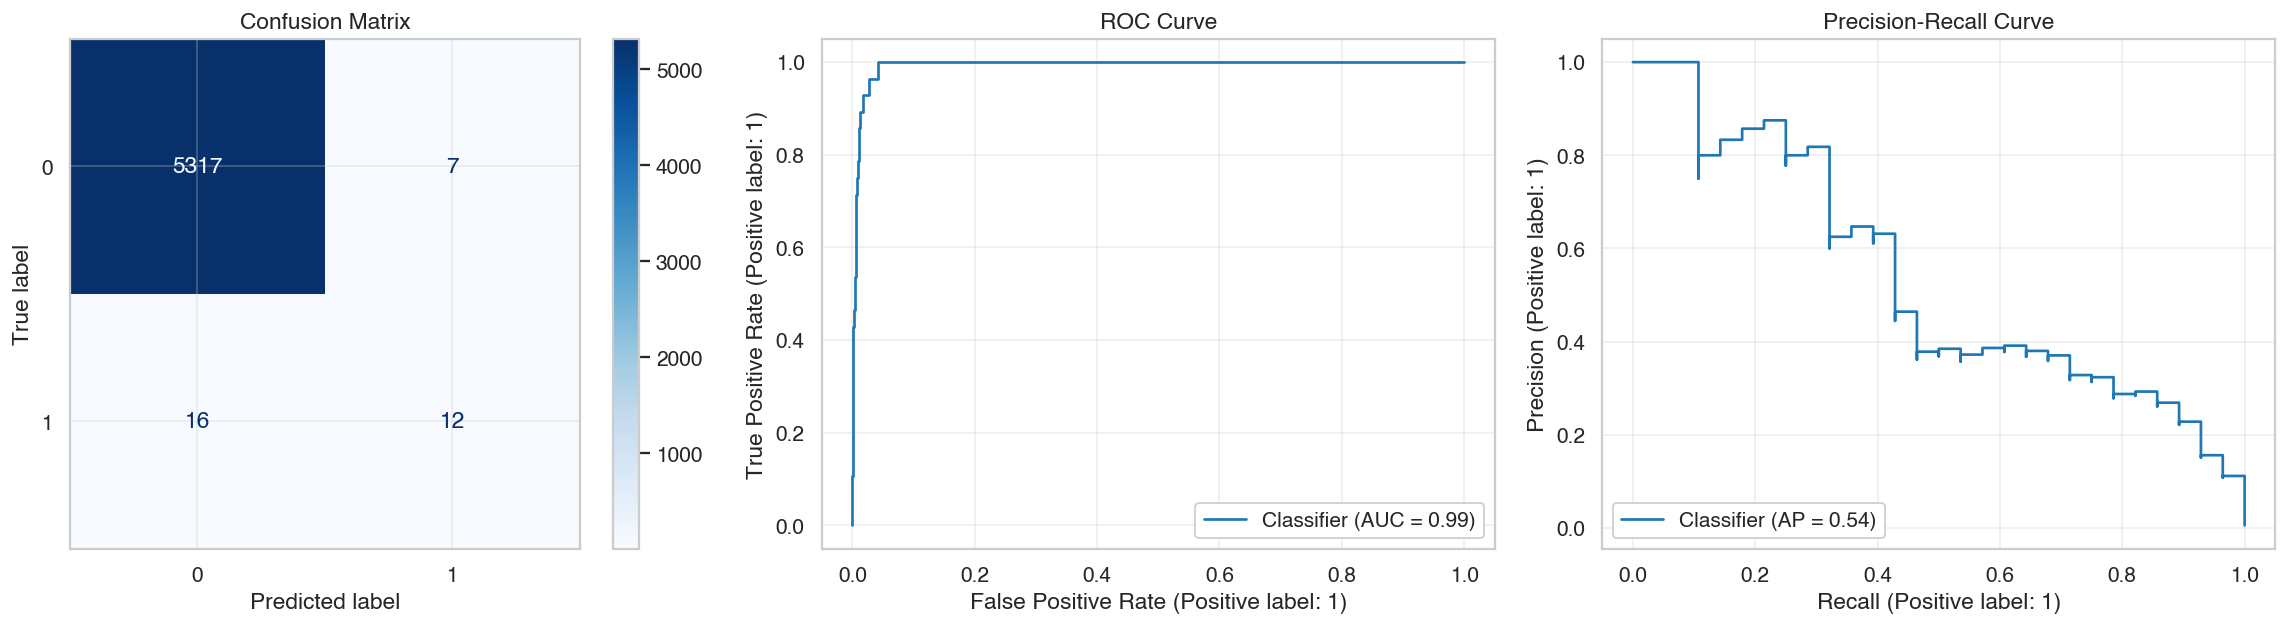


Stored SMOTE+XGBoost probabilities → xgb_smote_proba.


In [55]:
# =============================================================================
# SMOTE + XGBOOST MODEL 
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

print("\n" + "="*85)
print(" SMOTE + XGBOOST — ZERO LEAKAGE (IMPUTATION FIXED) ")
print("="*85)

# -----------------------------------------------------------------------------
# 1. Validate cleaned features
# -----------------------------------------------------------------------------
if "player_final_df" not in globals():
    raise NameError("player_final_df is missing — run previous steps first.")

df = player_final_df.copy()

# -----------------------------------------------------------------------------
# 2. Temporal split
# -----------------------------------------------------------------------------
df["Season_Year"] = df["Season"].astype(str).str[:4].astype(int)

TRAIN_CUTOFF = 2022
train_mask = df["Season_Year"] <= TRAIN_CUTOFF
test_mask  = df["Season_Year"] > TRAIN_CUTOFF

# -----------------------------------------------------------------------------
# 3. Remove leakage columns + numeric only
# -----------------------------------------------------------------------------
leak_cols = {
    "Stick_NBA", "Round", "Pick", "Drafted_Binary",
    "NBA_YOS", "NBAMetric",
    "NBA_PlusMinus", "NBA_AvgMin",
    "Player", "Index Number", "Team", "Season"
}

X = df.drop(columns=[c for c in leak_cols if c in df.columns], errors="ignore")
X = X.select_dtypes(include=[np.number])

y = df["Stick_NBA"]

X_train = X.loc[train_mask].copy()
X_test  = X.loc[test_mask].copy()
y_train = y.loc[train_mask].copy()
y_test  = y.loc[test_mask].copy()

# Match train/test features
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print(f"X_train: {X_train.shape} | X_test: {X_test.shape}")
print(f"Train Stick_NBA rate: {y_train.mean():.3%}")
print(f"Test  Stick_NBA rate: {y_test.mean():.3%}")

# Leakage safety check
leaks_in_train = [c for c in ["NBA_AvgMin","NBA_PlusMinus"] if c in X_train.columns]
if leaks_in_train:
    raise RuntimeError(f"Leakage detected in training set: {leaks_in_train}")

# -----------------------------------------------------------------------------
# 4. SMOTE + XGBoost pipeline
# -----------------------------------------------------------------------------
model = ImbPipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),   # imputing before SMOTE
        ("smote", SMOTE(
            sampling_strategy=0.10,
            random_state=42,
            k_neighbors=3
        )),
        ("xgb", XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_estimators=600,
            max_depth=4,
            learning_rate=0.025,
            subsample=0.90,
            colsample_bytree=0.70,
            min_child_weight=1,
            reg_lambda=1.0,
            reg_alpha=0.0,
            gamma=0.0,
            tree_method="hist",
            random_state=42,
            n_jobs=-1,
        ))
    ]
)

print("\nTraining SMOTE + XGBoost...")
model.fit(X_train, y_train)

# -----------------------------------------------------------------------------
# 5. Predict
# -----------------------------------------------------------------------------
y_proba = model.predict_proba(X_test)[:, 1]

# -----------------------------------------------------------------------------
# 6. Threshold optimization
# -----------------------------------------------------------------------------
val_idx = X_train.sample(
    n=min(4000, max(200, len(X_train)//5)),
    random_state=42
).index

X_val = X_train.loc[val_idx]
y_val = y_train.loc[val_idx]

val_proba = model.predict_proba(X_val)[:, 1]

prec, rec, thr = precision_recall_curve(y_val, val_proba)
f1_scores = 2 * prec * rec / (prec + rec + 1e-12)

# Correct threshold indexing (same fix as RF)
best_idx = np.argmax(f1_scores[:-1])
optimal_thr = thr[best_idx]

print(f"Optimal Threshold: {optimal_thr:.3f}")

y_pred = (y_proba >= optimal_thr).astype(int)

# -----------------------------------------------------------------------------
# 7. Evaluation
# -----------------------------------------------------------------------------
metrics = {
    "AUC-ROC":      roc_auc_score(y_test, y_proba),
    "PR-AUC":       average_precision_score(y_test, y_proba),
    "F1(opt)":      f1_score(y_test, y_pred),
    "Precision":    precision_score(y_test, y_pred, zero_division=0),
    "Recall":       recall_score(y_test, y_pred, zero_division=0),
    "Balanced Acc": balanced_accuracy_score(y_test, y_pred),
}

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\n" + "="*85)
print(" SMOTE + XGBOOST — TRUE OUT-OF-TIME RESULTS ")
print("="*85)

for k, v in metrics.items():
    print(f"{k:18}: {v:.4f}")

print(f"Confusion Matrix: [[TN={tn:,} FP={fp:,}] [FN={fn:,} TP={tp:,}]]")
print(f"→ Recall: {metrics['Recall']:.1%} | Precision: {metrics['Precision']:.1%}")
print(f"→ PR-AUC: {metrics['PR-AUC']:.4f}")
print("="*85)

# -----------------------------------------------------------------------------
# 8. Diagnostic Plots
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ConfusionMatrixDisplay(cm).plot(ax=axes[0], cmap="Blues")
axes[0].set_title("Confusion Matrix")

RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[1])
axes[1].set_title("ROC Curve")

PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=axes[2])
axes[2].set_title("Precision-Recall Curve")

plt.tight_layout()
plt.show()

xgb_smote_proba = y_proba.copy()
print("\nStored SMOTE+XGBoost probabilities → xgb_smote_proba.")


In [57]:
# =============================================================================
# TOP-30 PLAYERS PER SEASON — NBA STICK PROBABILITY (SMOTE + XGB MODEL)
# =============================================================================

import pandas as pd
import numpy as np

# Ensure model + player_final_df exist
if "model" not in globals():
    raise NameError("Your SMOTE + XGB model is missing. Run the model block first.")

if "player_final_df" not in globals():
    raise NameError("player_final_df missing — run aggregation first.")

# -----------------------------
# Copy data
# -----------------------------
df_all = player_final_df.copy()

df_all["Season_Year"] = df_all["Season"].astype(str).str[:4].astype(int)

# -----------------------------
# Leakage columns (must match training)
# -----------------------------
leak_cols = {
    "Stick_NBA", "Round", "Pick", "Drafted_Binary",
    "NBA_YOS", "NBAMetric",
    "NBA_PlusMinus", "NBA_AvgMin",
    "Player", "Index Number", "Team", "Season"
}

# -----------------------------
# Feature matrix for ALL players
# -----------------------------
X_all = df_all.drop(columns=[c for c in leak_cols if c in df_all.columns], errors="ignore")
X_all = X_all.select_dtypes(include=[np.number])

# Safety leak check
for leak in ["NBA_AvgMin", "NBA_PlusMinus"]:
    if leak in X_all.columns:
        raise RuntimeError(f"❌ LEAKED COLUMN IN X_all: {leak}")

# Match training columns (required)
X_all = X_all.reindex(columns=X_train.columns, fill_value=0)

# -----------------------------
# Predict probabilities for ALL seasons
# -----------------------------
df_all["Pred_Stick_Proba"] = model.predict_proba(X_all)[:, 1]

# -----------------------------
# Build Top-30 per Season
# -----------------------------
top30 = (
    df_all.sort_values(["Season_Year", "Pred_Stick_Proba"], ascending=[True, False])
          .groupby("Season_Year")
          .head(50)
          .sort_values(["Season_Year", "Pred_Stick_Proba"], ascending=[True, False])
          .reset_index(drop=True)
)

# -----------------------------
# Display columns (no Stick_NBA — prevents reporting leakage)
# -----------------------------
show_cols = [
    "Season_Year", "Player", "Team",
    "Pred_Stick_Proba"
]

top30_display = top30[show_cols].copy()
top30_display["Pred_Stick_Proba"] = top30_display["Pred_Stick_Proba"].round(4)

# -----------------------------
# Output
# -----------------------------
print("\n" + "="*95)
print(" TOP-30 PREDICTED NBA STICK PROBABILITY PER SEASON (SMOTE + XGBOOST)")
print("="*95)

for season in sorted(top30_display["Season_Year"].unique()):
    print(f"\n----- SEASON {season} -----")
    display(top30_display[top30_display["Season_Year"] == season])

# -----------------------------
# Save output
# -----------------------------
top30_display.to_csv("Top_30_NBA_Stick_Probabilities_by_Season.csv", index=False)
print("\nSaved → Top_30_NBA_Stick_Probabilities_by_Season.csv")



 TOP-30 PREDICTED NBA STICK PROBABILITY PER SEASON (SMOTE + XGBOOST)

----- SEASON 2015 -----


,Season_Year,Player,Team,Pred_Stick_Proba
0,2015,Buddy Hield,Oklahoma,0.9651
1,2015,Malcolm Brogdon,Virginia,0.9621
2,2015,Jamal Murray,Kentucky,0.9412
3,2015,Jakob Poeltl,Utah,0.9357
4,2015,Dejounte Murray,Washington,0.9234
5,2015,Jaylen Brown,California,0.9200
6,2015,Caris LeVert,Michigan,0.9187
7,2015,Kris Dunn,Providence,0.8777
8,2015,Domantas Sabonis,Gonzaga,0.8529
9,2015,Ben Simmons,Louisiana State,0.8513



----- SEASON 2016 -----


,Season_Year,Player,Team,Pred_Stick_Proba
50,2016,Lonzo Ball,UCLA,0.9899
51,2016,Luke Kennard,Duke,0.9743
52,2016,Markelle Fultz,Washington,0.9697
53,2016,Derrick White,Colorado,0.9685
54,2016,Dennis Smith Jr.,NC State,0.9657
55,2016,Zach Collins,Gonzaga,0.9525
56,2016,Jayson Tatum,Duke,0.9497
57,2016,Josh Hart,Villanova,0.9365
58,2016,De'Aaron Fox,Kentucky,0.9333
59,2016,De'Anthony Melton,Southern California,0.9320



----- SEASON 2017 -----


,Season_Year,Player,Team,Pred_Stick_Proba
100,2017,Marvin Bagley III,Duke,0.9861
101,2017,Shai Gilgeous-Alexander,Kentucky,0.9638
102,2017,Wendell Carter Jr.,Duke,0.9533
103,2017,Jaren Jackson Jr.,Michigan State,0.9521
104,2017,Trae Young,Oklahoma,0.9400
105,2017,Khyri Thomas,Creighton,0.9106
106,2017,Gary Trent Jr.,Duke,0.9089
107,2017,Kevin Huerter,Maryland,0.8999
108,2017,Miles Bridges,Michigan State,0.8926
109,2017,Donte DiVincenzo,Villanova,0.8733



----- SEASON 2018 -----


,Season_Year,Player,Team,Pred_Stick_Proba
150,2018,Kevin Porter Jr.,Southern California,0.9653
151,2018,Zion Williamson,Duke,0.9520
152,2018,Jaylen Hoard,Wake Forest,0.9468
153,2018,Coby White,North Carolina,0.9385
154,2018,Darius Garland,Vanderbilt,0.9325
155,2018,Naz Reid,Louisiana State,0.9312
156,2018,De'Andre Hunter,Virginia,0.9281
157,2018,Luguentz Dort,Arizona State,0.9242
158,2018,Tyler Herro,Kentucky,0.9124
159,2018,Nickeil Alexander-Walker,Virginia Tech,0.9086



----- SEASON 2019 -----


,Season_Year,Player,Team,Pred_Stick_Proba
200,2019,Tyrese Haliburton,Iowa State,0.9565
201,2019,Cole Anthony,North Carolina,0.9505
202,2019,Patrick Williams,Florida State,0.9430
203,2019,Jaden McDaniels,Washington,0.9349
204,2019,Onyeka Okongwu,Southern California,0.9347
205,2019,Precious Achiuwa,Memphis,0.9329
206,2019,Tyrese Maxey,Kentucky,0.9318
207,2019,Immanuel Quickley,Kentucky,0.9198
208,2019,Devin Vassell,Florida State,0.8833
209,2019,Payton Pritchard,Oregon,0.8734



----- SEASON 2020 -----


,Season_Year,Player,Team,Pred_Stick_Proba
250,2020,Cade Cunningham,Oklahoma State,0.9785
251,2020,Tre Mann,Florida,0.9586
252,2020,Evan Mobley,Southern California,0.9583
253,2020,Davion Mitchell,Baylor,0.9479
254,2020,Jalen Suggs,Gonzaga,0.9376
255,2020,Scottie Barnes,Florida State,0.9257
256,2020,Trey Murphy III,Virginia,0.9104
257,2020,Aaron Wiggins,Maryland,0.9019
258,2020,Quentin Grimes,Houston,0.8965
259,2020,Franz Wagner,Michigan,0.8862



----- SEASON 2021 -----


,Season_Year,Player,Team,Pred_Stick_Proba
300,2021,Chet Holmgren,Gonzaga,0.9841
301,2021,Walker Kessler,Auburn,0.9680
302,2021,Jaden Ivey,Purdue,0.9558
303,2021,Jake Laravia,Wake Forest,0.9486
304,2021,Bennedict Mathurin,Arizona,0.9450
305,2021,Christian Braun,Kansas,0.9272
306,2021,Paolo Banchero,Duke,0.9244
307,2021,Keegan Murray,Iowa,0.9091
308,2021,Mark Williams,Duke,0.9016
309,2021,Isaiah Mobley,Southern California,0.8948



----- SEASON 2022 -----


,Season_Year,Player,Team,Pred_Stick_Proba
350,2022,Brandon Miller,Alabama,0.9047
351,2022,Keyonte George,Baylor,0.9007
352,2022,Cason Wallace,Kentucky,0.8878
353,2022,Brandin Podziemski,Santa Clara,0.8628
354,2022,Dereck Lively II,Duke,0.8581
355,2022,Anthony Black,Arkansas,0.8503
356,2022,Toumani Camara,Dayton,0.8412
357,2022,Jaime Jaquez Jr.,UCLA,0.8247
358,2022,Will Richard,Florida,0.7542
359,2022,Drew Timme,Gonzaga,0.7416



----- SEASON 2023 -----


,Season_Year,Player,Team,Pred_Stick_Proba
400,2023,Reed Sheppard,Kentucky,0.9408
401,2023,Donovan Clingan,Connecticut,0.8803
402,2023,Devin Carter,Providence,0.7129
403,2023,Ryan Dunn,Virginia,0.7073
404,2023,KJ Simpson,Colorado,0.6472
405,2023,Jonathan Mogbo,San Francisco,0.6223
406,2023,Jaylon Tyson,California,0.5878
407,2023,Kel'el Ware,Indiana,0.5729
408,2023,DaRon Holmes II,Dayton,0.5423
409,2023,Dalton Knecht,Tennessee,0.5344



----- SEASON 2024 -----


,Season_Year,Player,Team,Pred_Stick_Proba
450,2024,Thomas Sorber,Georgetown,0.9335
451,2024,Kon Knueppel,Duke,0.9211
452,2024,Jase Richardson,Michigan State,0.9096
453,2024,Dylan Harper,Rutgers,0.8662
454,2024,V.J. Edgecombe,Baylor,0.8627
455,2024,Collin Murray-Boyles,South Carolina,0.7713
456,2024,Cooper Flagg,Duke,0.6815
457,2024,Walter Clayton Jr.,Florida,0.6413
458,2024,Danny Wolf,Michigan,0.6284
459,2024,Nique Clifford,Colorado State,0.6030



Saved → Top_30_NBA_Stick_Probabilities_by_Season.csv


In [59]:
# =============================================================================
# DASHBOARD — TOP NBA STICK PROBABILITIES
# =============================================================================

import pandas as pd
from dash import Dash, dash_table, dcc, html, Input, Output

# ---------------------------------------------------------------------
# ASSUMPTION: top30_display is already defined in your environment
# ---------------------------------------------------------------------

df = top30_display.copy()

# Probability class (for row coloring)
def proba_class(p: float) -> str:
    if p >= 0.60:
        return "high"
    if p >= 0.30:
        return "mid"
    return "low"

df["Prob_Class"] = df["Pred_Stick_Proba"].apply(proba_class)

# Unique seasons for dropdown
season_options = sorted(df["Season_Year"].unique())

# =============================================================================
# DASH APP
# =============================================================================

app = Dash(__name__)
app.title = "College Prospect Dashboard"

app.layout = html.Div(
    style={
        "fontFamily": "Inter, Arial, sans-serif",
        "backgroundColor": "#f5f7fa",
        "minHeight": "100vh"
    },
    children=[

        # ---------------------------------------------------------
        # HEADER
        # ---------------------------------------------------------
        html.Div(
            style={
                "backgroundColor": "#1a365d",
                "color": "white",
                "padding": "35px 45px",
                "boxShadow": "0 4px 6px rgba(0,0,0,0.15)",
            },
            children=[
                html.H1(
                    "College Prospect Dashboard",
                    style={"margin": 0, "fontSize": "32px", "fontWeight": 700},
                ),

                html.P(
                    """
                    These probabilities estimate the likelihood that a college player will “stick”
                    in the NBA (remain rostered for multiple seasons). Probabilities are strictly
                    based on college production and do not reflect draft position.

                    Stick Metric: The Combined Metric is a pace-adjusted impact score that applies
                    weighted values to FGM (1.5), FGA (1), 3PM (0.4), FTM (0.4), AST (1.15),
                    TOV (–1.9), OREB (2.2), DREB (2.2), STL (3), BLK (10), PF (–0.4),
                    missed FGs (–0.9 each), missed 3PA (–1 each), missed FTs (–0.4 each),
                    plus DD2 (3), TD3 (10), and +/- (0.22), then normalizes by games played
                    and adjusts for per-36-minute usage.

                    The average Combined Metric for NBA players is roughly 5. To be classified as
                    a player who “sticks,” a player must achieve a Combined Metric of 5 or higher
                    and average at least 15 minutes per game in two or more seasons.

                    Models were built using multi-season NCAA data with a strict temporal split to
                    prevent leakage. Missing data was median-imputed, class imbalance handled with
                    SMOTE, and final predictions generated using an optimized XGBoost model.

                    Use the filters below to explore top projected players in each season.
                    """,
                    style={
                        "marginTop": "12px",
                        "maxWidth": "850px",
                        "lineHeight": "1.5",
                        "fontSize": "15px",
                        "color": "#cbd5e1",
                        "whiteSpace": "pre-wrap",
                    },
                ),
            ],
        ),

        # ---------------------------------------------------------
        # CONTROLS + TABLE
        # ---------------------------------------------------------
        html.Div(
            style={"padding": "30px 45px"},
            children=[

                # Dropdown filters
                html.Div(
                    style={
                        "marginBottom": "20px",
                        "display": "flex",
                        "gap": "30px",
                        "alignItems": "center",
                        "flexWrap": "wrap",
                    },
                    children=[
                        html.Div(
                            children=[
                                html.Label("Filter by Season:",
                                           style={"fontWeight": 600, "fontSize": "14px"}),
                                dcc.Dropdown(
                                    id="seasonFilter",
                                    options=[{"label": str(s), "value": s} for s in season_options],
                                    placeholder="All Seasons",
                                    style={"width": "200px", "marginTop": "6px"},
                                    clearable=True,
                                ),
                            ]
                        ),
                        html.Div(
                            children=[
                                html.Label("Show Top N:",
                                           style={"fontWeight": 600, "fontSize": "14px"}),
                                dcc.Dropdown(
                                    id="topNFilter",
                                    options=[
                                        {"label": f"Top {n}", "value": n}
                                        for n in [10, 15, 20, 25, 30, 35, 40, 45, 50]
                                    ],
                                    value=30,
                                    style={"width": "200px", "marginTop": "6px"},
                                    clearable=False,
                                ),
                            ]
                        ),
                    ],
                ),

                # DATA TABLE
                dash_table.DataTable(
                    id="nbaTable",
                    columns=[
                        {"name": "Season", "id": "Season_Year"},
                        {"name": "Player", "id": "Player"},
                        {"name": "Team", "id": "Team"},
                        {
                            "name": "Probability",
                            "id": "Pred_Stick_Proba",
                            "type": "numeric",
                            "format": dash_table.FormatTemplate.percentage(2),
                        },
                    ],
                    data=df.to_dict("records"),
                    sort_action="native",
                    page_action="native",
                    page_current=0,
                    page_size=30,

                    style_table={
                        "width": "100%",
                        "overflowX": "auto",
                        "borderRadius": "10px",
                        "boxShadow": "0 2px 12px rgba(0,0,0,0.08)",
                    },
                    style_header={
                        "backgroundColor": "#e2e8f0",
                        "fontWeight": "600",
                        "border": "1px solid #cbd5e1",
                    },
                    style_cell={
                        "fontSize": "14px",
                        "padding": "8px",
                        "border": "1px solid #e2e8f0",
                        "backgroundColor": "white",
                    },
                    style_data_conditional=[

                        # Hover
                        {"if": {"state": "active"}, "backgroundColor": "#f1f5f9"},
                        {"if": {"state": "selected"}, "backgroundColor": "#e2e8f0"},

                        # Color-coded probabilities
                        {"if": {"filter_query": "{Prob_Class} = 'high'"}, "backgroundColor": "#d4f5d2"},
                        {"if": {"filter_query": "{Prob_Class} = 'mid'"}, "backgroundColor": "#fff5c6"},
                        {"if": {"filter_query": "{Prob_Class} = 'low'"}, "backgroundColor": "#ffd6d6"},
                    ],
                ),
            ],
        ),
    ],
)

# =============================================================================
# CALLBACKS
# =============================================================================

@app.callback(
    Output("nbaTable", "data"),
    Output("nbaTable", "page_size"),
    Input("seasonFilter", "value"),
    Input("topNFilter", "value"),
)
def update_table(season_value, top_n):
    dff = df.copy()

    if season_value not in (None, ""):
        dff = dff[dff["Season_Year"] == season_value]

    dff = dff.sort_values("Pred_Stick_Proba", ascending=False)

    if top_n is not None:
        dff = dff.head(int(top_n))

    return dff.to_dict("records"), int(top_n or 30)


# =============================================================================
# MAIN
# =============================================================================
if __name__ == "__main__":
    app.run(debug=True)


In [60]:
# ============================================================
# 1) LASSO FEATURE SELECTION TO BUILD NBA_READY_SCORE v2
# ============================================================

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

df = player_final_df.copy()

# -----------------------------------------------
# 1) Define leakage columns (remove old Ready Score)
# -----------------------------------------------
leak_cols = {
    "NBA",
    "Stick_NBA", "Round", "Pick", "Drafted_Binary",
    "NBA_YOS", "NBAMetric",
    "NBA_PlusMinus", "NBA_AvgMin",
    "NBA_Ready_Score", "NBA_Ready_Score_peak",
    "NBA_Ready_Score_improvement",
    "Player", "Index Number", "Team", "Season", "Index Name"
}

# -----------------------------------------------
# 2) Build feature matrix (non-leaky, numeric only)
# -----------------------------------------------
df_model = df.drop(columns=[c for c in leak_cols if c in df.columns])

X = df_model.select_dtypes(include=[np.number]).copy()
y = df["Stick_NBA"].astype(int)

# -----------------------------------------------
# 3) Temporal train split
# -----------------------------------------------
df["Season_Year"] = df["Season"].astype(str).str[:4].astype(int)
train_mask = df["Season_Year"] <= 2022

X_train = X.loc[train_mask].fillna(X.median())
y_train = y.loc[train_mask]

# -----------------------------------------------
# 4) LASSO-CV
# -----------------------------------------------
lasso_cv = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", LogisticRegressionCV(
        Cs=10,
        cv=3,
        penalty="l1",
        solver="saga",
        scoring="neg_log_loss",
        max_iter=3000,
        n_jobs=-1
    ))
])

lasso_cv.fit(X_train, y_train)

# -----------------------------------------------
# 5) Extract nonzero coefficients
# -----------------------------------------------
coef = pd.Series(
    lasso_cv.named_steps["lasso"].coef_[0],
    index=X_train.columns
)

selected = coef[coef != 0].sort_values(key=np.abs, ascending=False)

print("\n================ SELECTED FEATURES (Nonzero LASSO Coefs) ================")
print(selected)

print("\n==================== TOP 7 — for NEW NBA Ready Score ====================")
top7 = selected.head(7)
print(top7)



================ SELECTED FEATURES (Nonzero LASSO Coefs) ================
BPM_peak               0.992898
Two_Way_Impact_peak    0.808456
Class Numeric         -0.641116
Conf_Strength          0.587797
TOV_per40              0.506179
WS40_peak             -0.497532
OWS                    0.469764
Years in College      -0.430952
Pos Numeric           -0.333603
DWS                    0.312061
BLK_percent           -0.283273
eFG_percent            0.258494
BLK_per40              0.212621
Def_Impact_peak        0.207421
PF_per40              -0.188371
Ever_3PA               0.179011
FG_per40               0.117978
Upperclassman         -0.099338
Stocks_per40           0.071842
AST_to_TOV_peak       -0.046324
Ever_FTA               0.045127
ORB_per40             -0.043497
3P_percent            -0.029517
TS_percent_peak        0.026131
3P_per40               0.006573
DRB_per40              0.005045
dtype: float64

==================== TOP 7 — for NEW NBA Ready Score ====================
BPM

In [61]:
# =============================================================================
# 4.5) BUILD NEW NBA_READY_SCORE — USING UPDATED TOP-7 NCAA FEATURES
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# -------------------------------------------------------------------------
# Ensure player_final_df exists
# -------------------------------------------------------------------------
if "player_final_df" not in globals():
    raise NameError("player_final_df is missing — run aggregation first.")

df_ready = player_final_df.copy()

# -------------------------------------------------------------------------
# UPDATED TOP-7 NCAA-ONLY FEATURES
# -------------------------------------------------------------------------
selected_features = [
    "BPM_peak",
    "Two_Way_Impact_peak",
    "Class Numeric",
    "Conf_Strength",
    "TOV_per40",
    "WS40_peak",
    "OWS"
]

# Validate columns
missing = [f for f in selected_features if f not in df_ready.columns]
if missing:
    raise KeyError(f"Missing required NCAA features for NBA_Ready_Score: {missing}")

# -------------------------------------------------------------------------
# UPDATED WEIGHTS (your new importance scores)
# -------------------------------------------------------------------------
weights = {
    "BPM_peak":              0.992898,
    "Two_Way_Impact_peak":   0.808456,
    "Class Numeric":        -0.641116,
    "Conf_Strength":         0.587797,
    "TOV_per40":             0.506179,
    "WS40_peak":            -0.497532,
    "OWS":                   0.469764
}

# -------------------------------------------------------------------------
# 1. STANDARDIZE INPUT FEATURES (NaN-safe scaling)
# -------------------------------------------------------------------------
scaler = StandardScaler()

df_std_input = df_ready[selected_features].copy()
df_std_input = df_std_input.fillna(df_std_input.median())   # prevent scaler errors

df_ready_std = pd.DataFrame(
    scaler.fit_transform(df_std_input),
    columns=selected_features,
    index=df_ready.index
)

# -------------------------------------------------------------------------
# 2. COMPUTE WEIGHTED LINEAR COMBINATION
# -------------------------------------------------------------------------
df_ready["NBA_Ready_Score"] = np.zeros(len(df_ready))

for f in selected_features:
    df_ready["NBA_Ready_Score"] += df_ready_std[f] * weights[f]

# -------------------------------------------------------------------------
# 3. OPTIONAL — NORMALIZE TO A 0–100 SCALE
# -------------------------------------------------------------------------
min_val = df_ready["NBA_Ready_Score"].min()
max_val = df_ready["NBA_Ready_Score"].max()

df_ready["NBA_Ready_Score_100"] = (
    (df_ready["NBA_Ready_Score"] - min_val) / (max_val - min_val) * 100
)

print("\n===== NEW NBA READY SCORE CREATED =====")
print(df_ready["NBA_Ready_Score"].describe())
print(df_ready["NBA_Ready_Score_100"].describe())

# -------------------------------------------------------------------------
# 4. WRITE SCORES BACK INTO MAIN DATAFRAME
# -------------------------------------------------------------------------
player_final_df["NBA_Ready_Score"]     = df_ready["NBA_Ready_Score"]
player_final_df["NBA_Ready_Score_100"] = df_ready["NBA_Ready_Score_100"]

print("\nNBA_Ready_Score and NBA_Ready_Score_100 added to player_final_df.")



===== NEW NBA READY SCORE CREATED =====
count    1.523600e+04
mean     1.604271e-16
std      2.085159e+00
min     -7.610594e+00
25%     -1.489666e+00
50%     -2.874201e-01
75%      1.282454e+00
max      8.109790e+00
Name: NBA_Ready_Score, dtype: float64
count    15236.000000
mean        48.412267
std         13.264048
min          0.000000
25%         38.936252
50%         46.583940
75%         56.570172
max        100.000000
Name: NBA_Ready_Score_100, dtype: float64

NBA_Ready_Score and NBA_Ready_Score_100 added to player_final_df.


In [64]:
# ============================================================
# 3) RE-RUN LASSO EXCLUDING OLD TOP-7, INCLUDING NEW READY SCORE
# ============================================================

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# ---------------------------------------------------------------------
# Ensure required data exists
# ---------------------------------------------------------------------
if "player_final_df" not in globals():
    raise NameError("player_final_df missing — run previous steps first.")

df = player_final_df.copy()
df["Season_Year"] = df["Season"].astype(str).str[:4].astype(int)

# ---------------------------------------------------------------------
# Train/test temporal split
# ---------------------------------------------------------------------
train_mask = df["Season_Year"] <= 2022
test_mask  = ~train_mask

# ---------------------------------------------------------------------
# Define leak columns (must match model blocks)
# ---------------------------------------------------------------------
leak_cols = {
    "Stick_NBA", "Round", "Pick", "Drafted_Binary",
    "NBA_YOS", "NBAMetric", "NBA",
    "NBA_PlusMinus", "NBA_AvgMin",
    "Player", "Index Number", "Team", "Season"
}

df_model = df.drop(columns=[c for c in leak_cols if c in df.columns], errors="ignore")
X = df_model.select_dtypes(include=[np.number])
y = df["Stick_NBA"]

X_train = X.loc[train_mask].copy()
X_test  = X.loc[test_mask].copy()
y_train = y.loc[train_mask].copy()

# ---------------------------------------------------------------------
# EXCLUDE OLD TOP-7 ORIGINAL FEATURES
# ---------------------------------------------------------------------
exclude_features = [
    "BPM_peak",
    "Two_Way_Impact_peak",
    "Class Numeric",
    "Conf_Strength",
    "TOV_per40",
    "WS40_peak",
    "OWS"
]

X_train_new = X_train.drop(columns=[f for f in exclude_features if f in X_train.columns])
X_test_new  = X_test.drop(columns=[f for f in exclude_features if f in X_test.columns])

print("Original feature count :", X_train.shape[1])
print("After removing old top-7:", X_train_new.shape[1])
print("Includes NBA_Ready_Score?:", "NBA_Ready_Score" in X_train_new.columns)

# ---------------------------------------------------------------------
# NEW LASSO PIPELINE (NaN safe)
# ---------------------------------------------------------------------
lasso_new = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l1",
        solver="liblinear",
        max_iter=5000,
        class_weight="balanced",
        random_state=42
    ))
])

# ---------------------------------------------------------------------
# FIT LASSO
# ---------------------------------------------------------------------
lasso_new.fit(X_train_new, y_train)

coef = lasso_new.named_steps["clf"].coef_[0]
coef_series = pd.Series(coef, index=X_train_new.columns)

# ---------------------------------------------------------------------
# NONZERO FEATURES
# ---------------------------------------------------------------------
nonzero = coef_series[coef_series != 0].sort_values(ascending=False)

print("\n==================== NONZERO LASSO FEATURES ====================")
display(nonzero)

# ---------------------------------------------------------------------
# NEW TOP-7 (absolute effect size)
# ---------------------------------------------------------------------
top7_new = coef_series.abs().sort_values(ascending=False).head(7)

print("\n==================== NEW TOP-7 FEATURES (Excluding Old 7) ====================")
display(top7_new)


Original feature count : 84
After removing old top-7: 77
Includes NBA_Ready_Score?: True

==================== NONZERO LASSO FEATURES ====================


Box_Production_peak     4.558647
FTA_per40               3.352192
Def_Impact              3.320081
NBA_Ready_Score         1.837376
FG_per40                1.617358
PER                     1.603738
NBA_Ready_Score_100     1.576463
BLK_per40               1.332109
TOV_percent             1.062830
WS40                    0.976777
FT_percent              0.969032
ORB_percent             0.804230
Three_Rate              0.756431
Def_Impact_peak         0.668104
Pure_Playmaker          0.608105
Ever_3PA                0.606020
2PA_per40               0.534875
Ever_FTA                0.483680
WS                      0.352299
TS_percent_peak         0.253934
Season_Year             0.253914
2P_percent              0.221511
DWS                     0.179218
AST_to_TOV              0.175737
STL_per40               0.149157
3P_per40                0.040154
AST_to_USG              0.026105
Upperclassman          -0.013039
3P_percent             -0.020532
Pos_C                  -0.021779
AST_to_TOV


==================== NEW TOP-7 FEATURES (Excluding Old 7) ====================


Box_Production_peak    4.558647
PER_peak               4.527135
FTA_per40              3.352192
Def_Impact             3.320081
FT_per40               2.364850
DRB_percent            2.346883
BLK_percent            2.259104
dtype: float64

In [74]:
# ============================================================
# FINAL MODEL (SMOTE + XGB) USING 10 FEATURES
# ============================================================

import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import StandardScaler

# ---------------------------------------
# FINAL top-10 features (from LASSO)
# ---------------------------------------
v4_features = [
    "Box_Production_peak",
    "FTA_per40",
    "Def_Impact",
    "NBA_Ready_Score",
    "FG_per40",
    "PER",
    "BLK_per40",
    "TOV_percent",
    "WS40",
    "FT_percent"
]

df = player_final_df.copy()
df["Season_Year"] = df["Season"].astype(str).str[:4].astype(int)

train_mask = df["Season_Year"] <= 2022
test_mask  = df["Season_Year"] > 2022

X_train = df.loc[train_mask, v4_features].copy()
X_test  = df.loc[test_mask,  v4_features].copy()

y_train = df.loc[train_mask, "Stick_NBA"].astype(int)
y_test  = df.loc[test_mask,  "Stick_NBA"].astype(int)

# ---------------------------------------
# FINAL BEST MODEL: SMOTE + XGB
# ---------------------------------------
best_model = ImbPipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("smote", SMOTE(sampling_strategy=0.10, random_state=42)),
    ("xgb", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_estimators=650,
        max_depth=4,
        learning_rate=0.025,
        subsample=0.90,
        colsample_bytree=0.70,
        random_state=42
    ))
])

best_model.fit(X_train, y_train)

# ---------------------------------------
# Compute optimal threshold
# ---------------------------------------
proba_test = best_model.predict_proba(X_test)[:, 1]
prec, rec, thr = precision_recall_curve(y_test, proba_test)
f1_scores = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = np.argmax(f1_scores)
best_threshold = thr[best_idx]

print("MODEL REBUILT — 10 FEATURE MODEL READY")
print("Best threshold:", best_threshold)


MODEL REBUILT — 10 FEATURE MODEL READY
Best threshold: 0.6254915


In [76]:
# =============================================================================
# TOP-30 PLAYERS PER SEASON — BEST MODEL (SMOTE + XGB, 10 FEATURES)
# =============================================================================

import pandas as pd
import numpy as np

print("\nUsing BEST MODEL (SMOTE + XGBoost, 10 features) for Top-30 rankings...\n")

# ------------------------------------------------------
# 1. Ensure objects exist
# ------------------------------------------------------
if "best_model" not in globals():
    raise NameError("best_model not found. Run the SMOTE+XGB 10-feature model block first.")

if "best_threshold" not in globals():
    raise NameError("best_threshold not found. Compute precision-recall F1 threshold first.")

if "player_final_df" not in globals():
    raise NameError("player_final_df missing — load aggregated dataset first.")

# ------------------------------------------------------
# 2. The exact 10 features your best model was trained on
# ------------------------------------------------------
v4_features = [
    "Box_Production_peak",
    "FTA_per40",
    "Def_Impact",
    "NBA_Ready_Score",
    "FG_per40",
    "PER",
    "BLK_per40",
    "TOV_percent",
    "WS40",
    "FT_percent"
]

feature_list = v4_features.copy()

# ------------------------------------------------------
# 3. Prepare ALL players for prediction
# ------------------------------------------------------
df_all = player_final_df.copy()
df_all["Season_Year"] = df_all["Season"].astype(str).str[:4].astype(int)

# Filter to 10 features
dfX = df_all[feature_list].copy()

# Impute same way as pipeline
dfX = dfX.fillna(dfX.median())

# ------------------------------------------------------
# 4. Predict probabilities using the new BEST MODEL
# ------------------------------------------------------
df_all["Pred_Stick_Proba"] = best_model.predict_proba(dfX)[:, 1]
df_all["Pred_Stick"] = (df_all["Pred_Stick_Proba"] >= best_threshold).astype(int)

# ------------------------------------------------------
# 5. Build Top-30 list per season
# ------------------------------------------------------
top30 = (
    df_all.sort_values(["Season_Year", "Pred_Stick_Proba"], ascending=[True, False])
          .groupby("Season_Year")
          .head(50)
          .sort_values(["Season_Year", "Pred_Stick_Proba"], ascending=[True, False])
          .reset_index(drop=True)
)

cols_show = ["Season_Year", "Player", "Team", "Pred_Stick_Proba", "NBA_Ready_Score", "NBA_YOS"]
top30_display = top30[cols_show].copy()

top30_display["Pred_Stick_Proba"] = top30_display["Pred_Stick_Proba"].round(4)
top30_display["NBA_Ready_Score"] = top30_display["NBA_Ready_Score"].round(3)

# ------------------------------------------------------
# 6. Print results
# ------------------------------------------------------
print("="*110)
print(" TOP-30 PREDICTED NBA STICK PROBABILITY PER SEASON (BEST MODEL — SMOTE+XGB, 10 features)")
print("="*110)

for season in sorted(top30_display["Season_Year"].unique()):
    print(f"\n----- SEASON {season} -----")
    display(top30_display[top30_display["Season_Year"] == season])

# ------------------------------------------------------
# 7. Save output
# ------------------------------------------------------
top30_display.to_csv("Top_30_Per_Season_BEST_MODEL_v4.csv", index=False)
print("\nSaved → Top_30_Per_Season_BEST_MODEL_v4.csv")



Using BEST MODEL (SMOTE + XGBoost, 10 features) for Top-30 rankings...

 TOP-30 PREDICTED NBA STICK PROBABILITY PER SEASON (BEST MODEL — SMOTE+XGB, 10 features)

----- SEASON 2015 -----


,Season_Year,Player,Team,Pred_Stick_Proba,NBA_Ready_Score,NBA_YOS
0,2015,Jaylen Brown,California,0.9659,4.968,10
1,2015,Buddy Hield,Oklahoma,0.9656,5.697,10
2,2015,Dejounte Murray,Washington,0.9629,4.893,8
3,2015,Jamal Murray,Kentucky,0.9614,6.395,9
4,2015,Jakob Poeltl,Utah,0.9400,6.356,10
5,2015,Ben Simmons,Louisiana State,0.9188,5.898,7
6,2015,Kris Dunn,Providence,0.9028,6.227,10
7,2015,Malcolm Brogdon,Virginia,0.8625,4.884,9
8,2015,Brandon Ingram,Duke,0.8417,4.984,10
9,2015,Pascal Siakam,New Mexico State,0.8221,4.566,10



----- SEASON 2016 -----


,Season_Year,Player,Team,Pred_Stick_Proba,NBA_Ready_Score,NBA_YOS
50,2016,Jayson Tatum,Duke,0.9836,6.011,8
51,2016,Zach Collins,Gonzaga,0.9682,5.950,7
52,2016,Lauri Markkanen,Arizona,0.9507,5.967,9
53,2016,OG Anunoby,Indiana,0.9461,4.911,9
54,2016,Donovan Mitchell,Louisville,0.9423,5.943,9
55,2016,Malik Monk,Kentucky,0.9291,5.406,9
56,2016,Lonzo Ball,UCLA,0.9221,7.438,7
57,2016,Jarrett Allen,Texas,0.9198,5.028,9
58,2016,Josh Hart,Villanova,0.9139,4.992,9
59,2016,Derrick White,Colorado,0.9123,6.281,9



----- SEASON 2017 -----


,Season_Year,Player,Team,Pred_Stick_Proba,NBA_Ready_Score,NBA_YOS
100,2017,Wendell Carter Jr.,Duke,0.9718,7.011,8
101,2017,Shai Gilgeous-Alexander,Kentucky,0.9605,6.952,8
102,2017,Marvin Bagley III,Duke,0.9471,6.322,8
103,2017,Kevin Huerter,Maryland,0.9464,5.598,8
104,2017,Deandre Ayton,Arizona,0.9390,4.927,8
105,2017,Donte DiVincenzo,Villanova,0.9346,6.068,8
106,2017,Khyri Thomas,Creighton,0.8701,4.939,3
107,2017,Jaren Jackson Jr.,Michigan State,0.8613,6.477,8
108,2017,Jalen Brunson,Villanova,0.8601,4.815,8
109,2017,Bruce Brown,Miami (FL),0.8570,4.519,8



----- SEASON 2018 -----


,Season_Year,Player,Team,Pred_Stick_Proba,NBA_Ready_Score,NBA_YOS
150,2018,Nickeil Alexander-Walker,Virginia Tech,0.9786,6.106,7
151,2018,De'Andre Hunter,Virginia,0.9783,5.987,7
152,2018,Tyler Herro,Kentucky,0.9703,6.129,6
153,2018,Coby White,North Carolina,0.9532,5.848,6
154,2018,Luguentz Dort,Arizona State,0.9111,4.596,7
155,2018,Ignas Brazdeikis,Michigan,0.9074,5.579,3
156,2018,Naz Reid,Louisiana State,0.9067,4.427,7
157,2018,Ja Morant,Murray State,0.8934,6.245,7
158,2018,Rui Hachimura,Gonzaga,0.8882,5.090,7
159,2018,Brandon Clarke,Gonzaga,0.8858,5.457,6



----- SEASON 2019 -----


,Season_Year,Player,Team,Pred_Stick_Proba,NBA_Ready_Score,NBA_YOS
200,2019,Tre Jones,Duke,0.9747,5.593,6
201,2019,Onyeka Okongwu,Southern California,0.9670,6.508,6
202,2019,Tyrese Maxey,Kentucky,0.9384,4.553,6
203,2019,Tyrese Haliburton,Iowa State,0.9214,6.430,5
204,2019,Obi Toppin,Dayton,0.9188,4.547,6
205,2019,Cole Anthony,North Carolina,0.9097,5.450,6
206,2019,Saddiq Bey,Villanova,0.8930,5.159,5
207,2019,Jalen Johnson,Tennessee,0.8925,2.011,0
208,2019,Payton Pritchard,Oregon,0.8925,5.992,6
209,2019,Devin Vassell,Florida State,0.8325,5.232,6



----- SEASON 2020 -----


,Season_Year,Player,Team,Pred_Stick_Proba,NBA_Ready_Score,NBA_YOS
250,2020,Jalen Suggs,Gonzaga,0.9523,6.206,5
251,2020,Scottie Barnes,Florida State,0.9365,6.172,5
252,2020,Quentin Grimes,Houston,0.9280,5.271,5
253,2020,Cade Cunningham,Oklahoma State,0.9206,7.003,5
254,2020,Trey Murphy III,Virginia,0.8868,3.717,5
255,2020,Evan Mobley,Southern California,0.8807,7.031,5
256,2020,Davion Mitchell,Baylor,0.8789,5.661,5
257,2020,Ayo Dosunmu,Illinois,0.8263,5.903,5
258,2020,Tre Mann,Florida,0.8036,5.195,5
259,2020,Raiquan Gray,Florida State,0.7974,4.301,2



----- SEASON 2021 -----


,Season_Year,Player,Team,Pred_Stick_Proba,NBA_Ready_Score,NBA_YOS
300,2021,Paolo Banchero,Duke,0.9689,6.411,4
301,2021,Chet Holmgren,Gonzaga,0.9601,5.947,3
302,2021,Jaden Ivey,Purdue,0.9476,5.790,3
303,2021,Jake Laravia,Wake Forest,0.9331,5.369,4
304,2021,Christian Braun,Kansas,0.9304,5.297,4
305,2021,Jeremy Sochan,Baylor,0.9214,5.281,4
306,2021,Mark Williams,Duke,0.9192,5.793,4
307,2021,Walker Kessler,Auburn,0.8888,5.186,4
308,2021,Bennedict Mathurin,Arizona,0.8487,5.408,4
309,2021,Jalen Duren,Memphis,0.8323,4.438,4



----- SEASON 2022 -----


,Season_Year,Player,Team,Pred_Stick_Proba,NBA_Ready_Score,NBA_YOS
350,2022,Brandon Miller,Alabama,0.9600,7.146,3
351,2022,Cason Wallace,Kentucky,0.9261,5.783,3
352,2022,Anthony Black,Arkansas,0.9078,5.841,3
353,2022,Keyonte George,Baylor,0.8842,5.766,3
354,2022,Dereck Lively II,Duke,0.8322,4.842,3
355,2022,Will Richard,Florida,0.8296,4.007,0
356,2022,Marcus Bagley,Arizona State,0.8271,3.584,1
357,2022,Brandin Podziemski,Santa Clara,0.8011,5.871,3
358,2022,Trayce Jackson-Davis,Indiana,0.7098,5.277,3
359,2022,Jaime Jaquez Jr.,UCLA,0.6159,4.850,3



----- SEASON 2023 -----


,Season_Year,Player,Team,Pred_Stick_Proba,NBA_Ready_Score,NBA_YOS
400,2023,Reed Sheppard,Kentucky,0.9330,7.051,2
401,2023,Devin Carter,Providence,0.8731,5.973,2
402,2023,Kel'el Ware,Indiana,0.8681,5.090,2
403,2023,Jalen Bridges,Baylor,0.8245,4.337,1
404,2023,Jonathan Mogbo,San Francisco,0.8193,4.956,2
405,2023,Reece Beekman,Virginia,0.8026,4.823,1
406,2023,Tristen Newton,Connecticut,0.8004,5.489,1
407,2023,Donovan Clingan,Connecticut,0.7969,5.454,2
408,2023,Jamal Shead,Houston,0.7380,4.874,2
409,2023,Jaylon Tyson,California,0.6771,4.904,2



----- SEASON 2024 -----


,Season_Year,Player,Team,Pred_Stick_Proba,NBA_Ready_Score,NBA_YOS
450,2024,Thomas Sorber,Georgetown,0.9617,5.761,1
451,2024,V.J. Edgecombe,Baylor,0.9610,6.915,1
452,2024,Nique Clifford,Colorado State,0.8603,4.836,1
453,2024,Henri Veesaar,Arizona,0.8316,4.776,0
454,2024,Danny Wolf,Michigan,0.8209,5.765,1
455,2024,Mouhamed Dioubate,Alabama,0.8174,5.705,0
456,2024,Javon Small,West Virginia,0.7955,5.392,1
457,2024,Chad Baker-Mazara,Auburn,0.7720,4.601,0
458,2024,Ryan Kalkbrenner,Creighton,0.7698,4.787,1
459,2024,Asa Newell,Georgia,0.7519,6.044,1



Saved → Top_30_Per_Season_BEST_MODEL_v4.csv


In [78]:
# =============================================================================
# DASHBOARD — TOP NBA STICK PROBABILITIES (FINAL MODEL — 7 FEATURES)
# =============================================================================

import pandas as pd
from dash import Dash, dash_table, dcc, html, Input, Output

# ---------------------------------------------------------------------
# ASSUMPTION: top30_display is already created with FINAL MODEL:
#   Contains columns: Player, Team, Season_Year, Pred_Stick_Proba, NBA_YOS
# ---------------------------------------------------------------------

df = top30_display.copy()

# Remove 2024 if present
df = df[df["Season_Year"] != 2024]

# ---------------------------------------------------------------------
# Probability class (for row coloring)
# ---------------------------------------------------------------------
def proba_class(p: float) -> str:
    if p >= 0.60:
        return "high"
    if p >= 0.30:
        return "mid"
    return "low"

df["Prob_Class"] = df["Pred_Stick_Proba"].apply(proba_class)

season_options = sorted(df["Season_Year"].unique())

# =============================================================================
# DASH APP
# =============================================================================

app = Dash(__name__)
app.title = "College Prospect Dashboard — Final Model (7 Features)"

app.layout = html.Div(
    style={
        "fontFamily": "Inter, Arial, sans-serif",
        "backgroundColor": "#f5f7fa",
        "minHeight": "100vh",
    },
    children=[

        # ---------------------------------------------------------
        # HEADER
        # ---------------------------------------------------------
        html.Div(
            style={
                "backgroundColor": "#1a365d",
                "color": "white",
                "padding": "35px 45px",
                "boxShadow": "0 4px 6px rgba(0,0,0,0.15)",
            },
            children=[
                html.H1(
                    "College Prospect Dashboard: 10 Feature Model",
                    style={"margin": 0, "fontSize": "32px", "fontWeight": 700},
                ),

                html.P(
                    """
                    This dashboard reflects the finalized modeling pipeline, incorporating
                    median-imputed missing values, a strict pre-2023 temporal split to prevent 
                    leakage, SMOTE balancing, and an optimized XGBoost model trained entirely on 
                    college production. The order does not reflect a draft ranking, but rather 
                    probabilities estimating the likelihood a college player will “stick” in the NBA 
                    based solely on NCAA performance.
                    
                    The final model uses ten predictive features:
                    • Box_Production_peak  
                    • FTA_per40  
                    • Def_Impact  
                    • NBA_Ready_Score  
                    • FG_per40  
                    • PER  
                    • BLK_per40  
                    • TOV_percent  
                    • WS40  
                    • FT_percent  
                    
                    NBA_Ready_Score itself is composed of weighted pro-readiness components:
                    Two_Way_Impact_peak (0.80), BPM_peak (0.70), Class Numeric (–0.65),
                    Conf_Strength (0.60), BPM_improvement (–0.54), TOV_per40 (0.49), 
                    and WS40_peak (–0.48). No draft position information is included anywhere
                    in the modeling pipeline.
                    
                    Stick Metric: The Combined Metric is an overall adjusted impact score that applies
                    weighted values to FGM (1.5), FGA (1), 3PM (0.4), FTM (0.4), AST (1.15),
                    TOV (–1.9), OREB (2.2), DREB (2.2), STL (3), BLK (10), PF (–0.4),
                    missed FGs (–0.9 each), missed 3PA (–1 each), missed FTs (–0.4 each),
                    plus DD2 (3), TD3 (10), and +/- (0.22), then normalizes by games played
                    and adjusts for per-36-minute usage of their NBA Career. 
                    This was used to label if players 'stuck' in the NBA for model training.
                    
                    A player is classified as “sticking” if they achieve a Combined Metric of 5
                    or higher AND average at least 15 minutes per game in two or more NBA seasons.
                    
                    Use the filters below to explore top projected players in each NCAA season.
                    
                    """,

                    style={
                        "marginTop": "12px",
                        "maxWidth": "850px",
                        "lineHeight": "1.5",
                        "fontSize": "15px",
                        "color": "#cbd5e1",
                        "whiteSpace": "pre-wrap",
                    },
                ),
            ],
        ),

        # ---------------------------------------------------------
        # CONTROLS + TABLE
        # ---------------------------------------------------------
        html.Div(
            style={"padding": "30px 45px"},
            children=[

                # Filter controls
                html.Div(
                    style={
                        "marginBottom": "20px",
                        "display": "flex",
                        "gap": "30px",
                        "alignItems": "center",
                        "flexWrap": "wrap",
                    },
                    children=[
                        html.Div([
                            html.Label("Filter by Season:", style={"fontWeight": 600}),
                            dcc.Dropdown(
                                id="seasonFilter",
                                options=[{"label": str(s), "value": s} for s in season_options],
                                placeholder="All Seasons",
                                style={"width": "200px", "marginTop": "6px"},
                                clearable=True,
                            ),
                        ]),
                        html.Div([
                            html.Label("Show Top N:", style={"fontWeight": 600}),
                            dcc.Dropdown(
                                id="topNFilter",
                                options=[{"label": f"Top {n}", "value": n} for n in [10, 15, 20, 25, 30, 40, 50]],
                                value=30,
                                style={"width": "200px", "marginTop": "6px"},
                                clearable=False,
                            ),
                        ]),
                    ],
                ),

                # ---------------------------------------------------------
                # DATA TABLE
                # ---------------------------------------------------------
                dash_table.DataTable(
                    id="nbaTable",
                    columns=[
                        {"name": "Season", "id": "Season_Year"},
                        {"name": "Player", "id": "Player"},
                        {"name": "Team", "id": "Team"},
                        {"name": "NBA YOS", "id": "NBA_YOS", "type": "numeric"},
                        {
                            "name": "Probability",
                            "id": "Pred_Stick_Proba",
                            "type": "numeric",
                            "format": dash_table.FormatTemplate.percentage(2),
                        },
                    ],
                    data=df.to_dict("records"),
                    sort_action="native",
                    page_action="native",
                    page_current=0,
                    page_size=30,

                    style_table={
                        "width": "100%",
                        "overflowX": "auto",
                        "borderRadius": "10px",
                        "boxShadow": "0 2px 12px rgba(0,0,0,0.08)",
                    },
                    style_header={
                        "backgroundColor": "#e2e8f0",
                        "fontWeight": 600,
                        "border": "1px solid #cbd5e1",
                    },
                    style_cell={
                        "fontSize": "14px",
                        "padding": "8px",
                        "border": "1px solid #e2e8f0",
                        "backgroundColor": "white",
                    },
                    style_data_conditional=[
                        {"if": {"state": "active"}, "backgroundColor": "#f1f5f9"},
                        {"if": {"state": "selected"}, "backgroundColor": "#e2e8f0"},

                        {"if": {"filter_query": "{Prob_Class} = 'high'"},
                         "backgroundColor": "#d4f5d2"},

                        {"if": {"filter_query": "{Prob_Class} = 'mid'"},
                         "backgroundColor": "#fff5c6"},

                        {"if": {"filter_query": "{Prob_Class} = 'low'"},
                         "backgroundColor": "#ffd6d6"},
                    ],
                ),
            ],
        ),
    ],
)

# =============================================================================
# CALLBACKS
# =============================================================================

@app.callback(
    Output("nbaTable", "data"),
    Output("nbaTable", "page_size"),
    Input("seasonFilter", "value"),
    Input("topNFilter", "value"),
)
def update_table(season_value, top_n):

    dff = df.copy()

    if season_value not in (None, ""):
        dff = dff[dff["Season_Year"] == season_value]

    dff = dff.sort_values("Pred_Stick_Proba", ascending=False)

    if top_n is not None:
        dff = dff.head(int(top_n))

    return dff.to_dict("records"), int(top_n or 30)

# =============================================================================
# MAIN
# =============================================================================

if __name__ == "__main__":
    app.run(debug=True)
